In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from model import Market
import seaborn as sns
from agents import Firm
from model import Market

import networkx as nx


In [2]:
n_households = 500
n_firms = 50
firms_production = 12
min_income = 0
max_income = 10
min_quality = 0
max_quality = 1
decrease_price = 0.2
increase_price = 0.1
price_change = 0.01
toy_mode = False

model = Market(F=n_firms, H=n_households, firms_production=firms_production,
                min_income=min_income, max_income=max_income, 
                min_quality=min_quality, max_quality=max_quality,
                decrease_price=decrease_price, increase_price=increase_price,
                price_change=price_change, toy_mode=toy_mode )
steps = 1000
for i in range(steps):
    #print('step', i)
    model.step()
    

/Users/todd/WWCS_2023_markets/env/lib/python3.9/site-packages/scipy/sparse/_base.py:752: VisibleDeprecationWarning: Please use `.todense()` instead
  warn(np.VisibleDeprecationWarning(


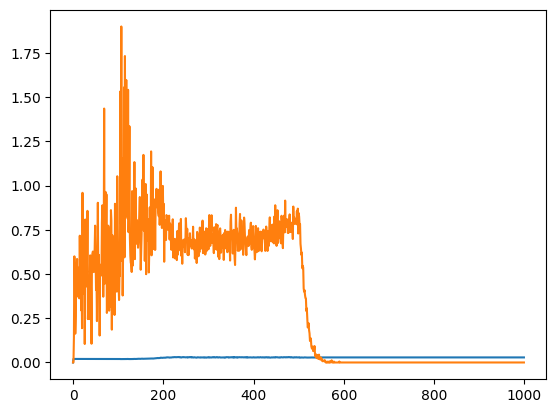

HHI  Distance
0    0.000000  0.000000
1    0.020000  0.000000
2    0.020000  0.141975
3    0.020000  0.600000
4    0.020000  0.500000
..        ...       ...
995  0.028605  0.000000
996  0.028605  0.000000
997  0.028605  0.000000
998  0.028605  0.000000
999  0.028605  0.000000

[1000 rows x 2 columns]

In [3]:
a = model.datacollector.get_model_vars_dataframe()
a['HHI'].plot()
a['Distance'].plot()
plt.show()
a

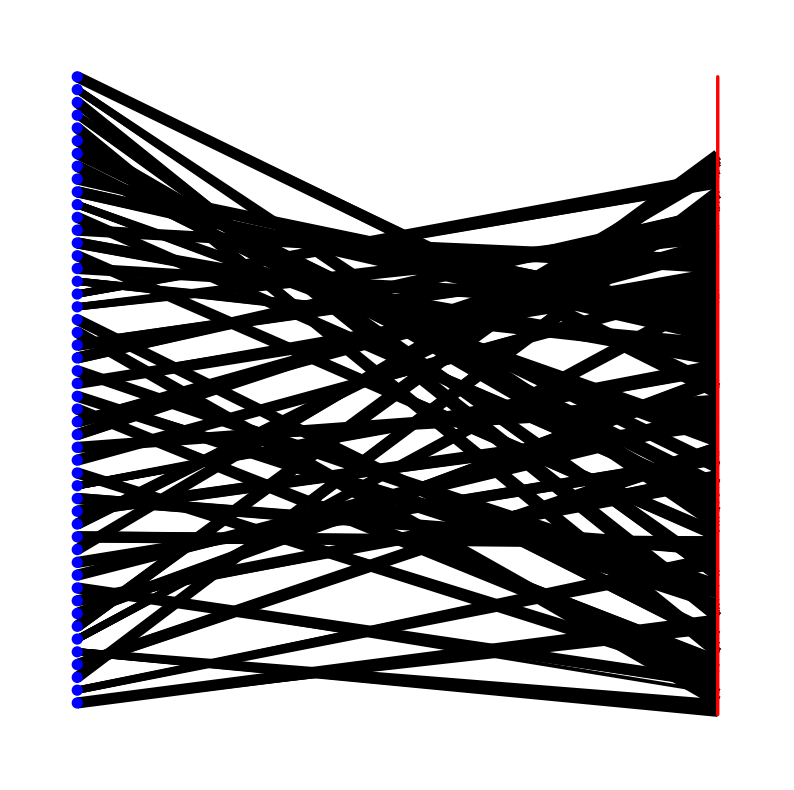

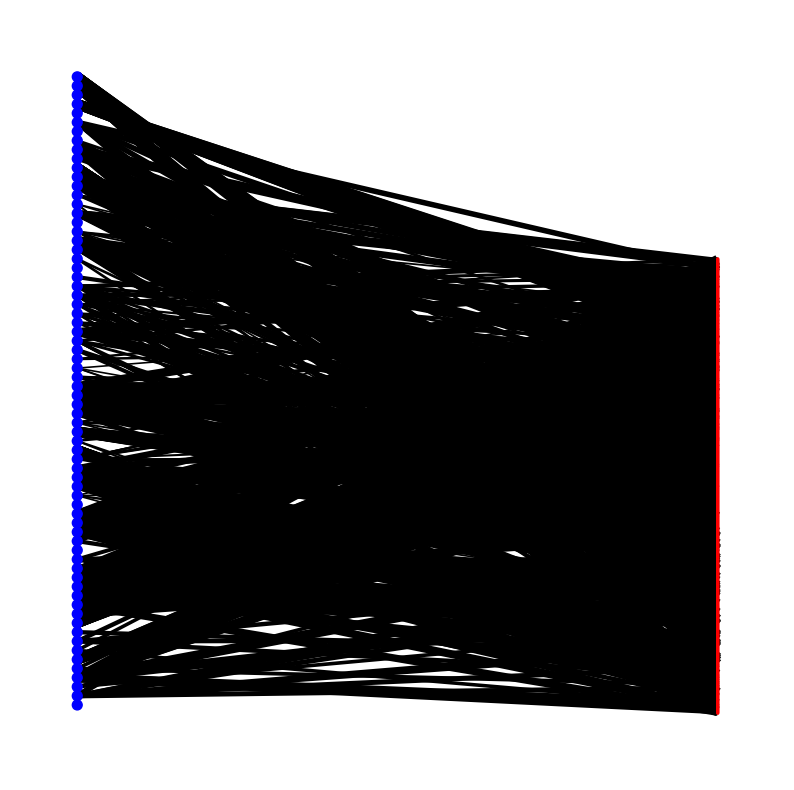

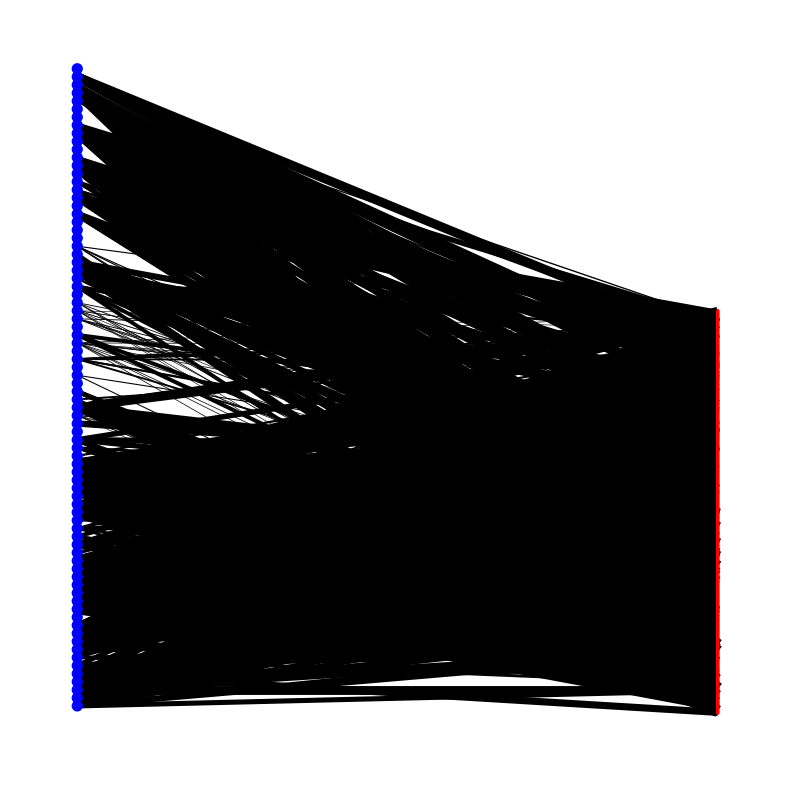

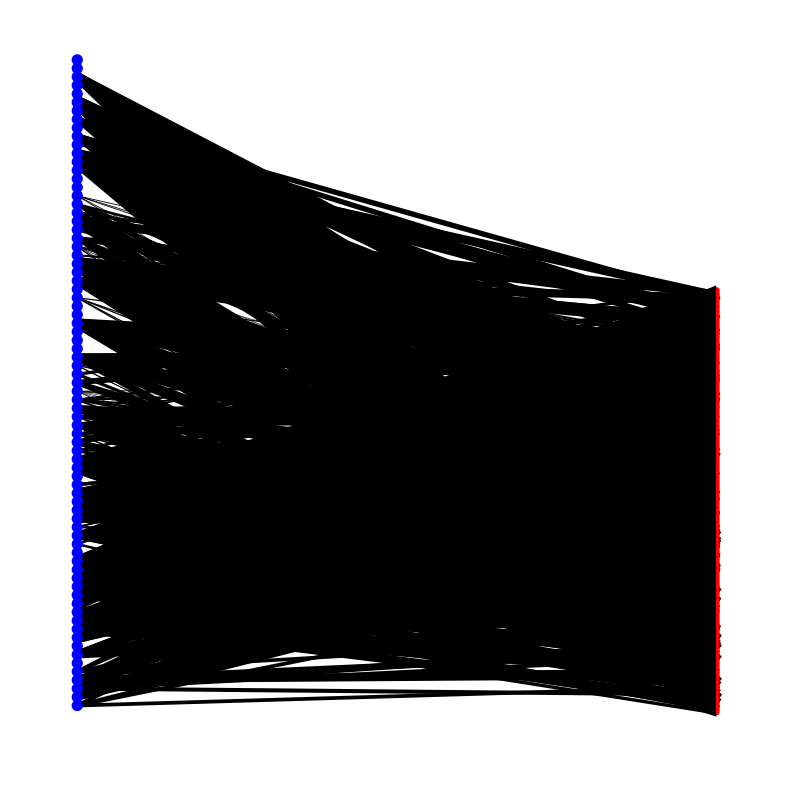

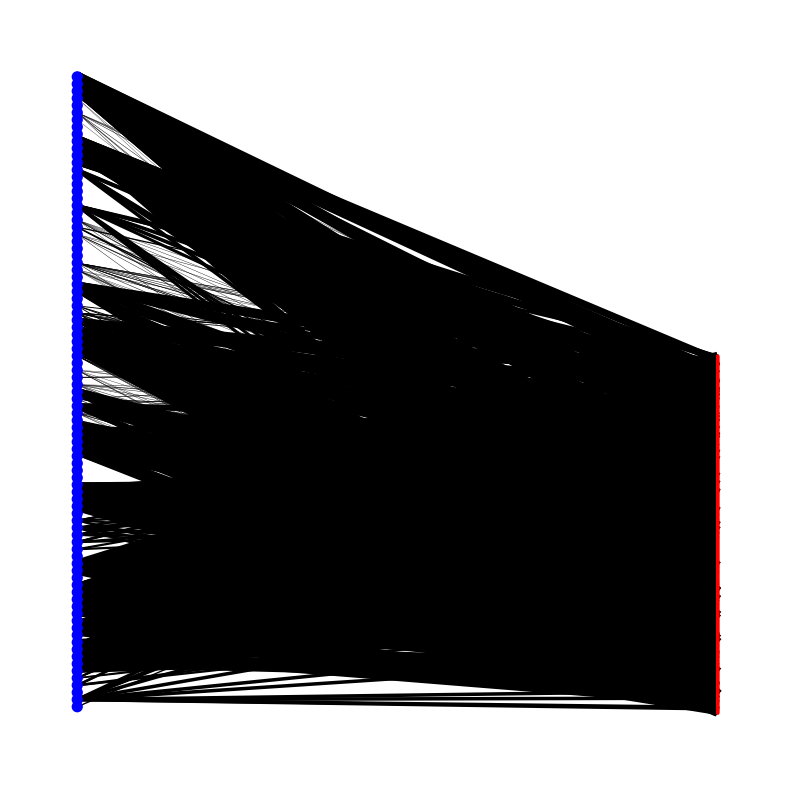

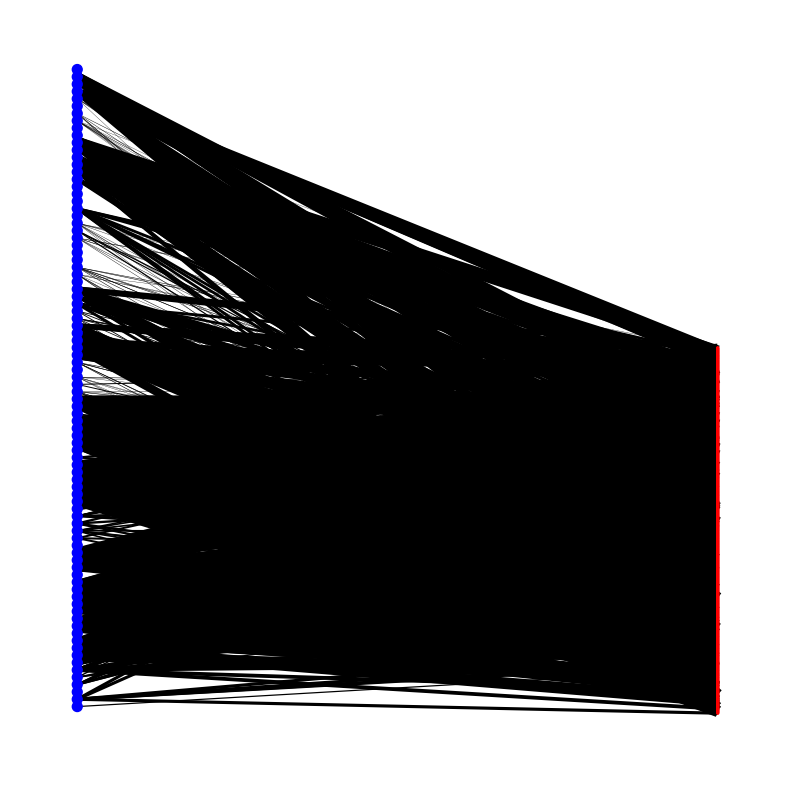

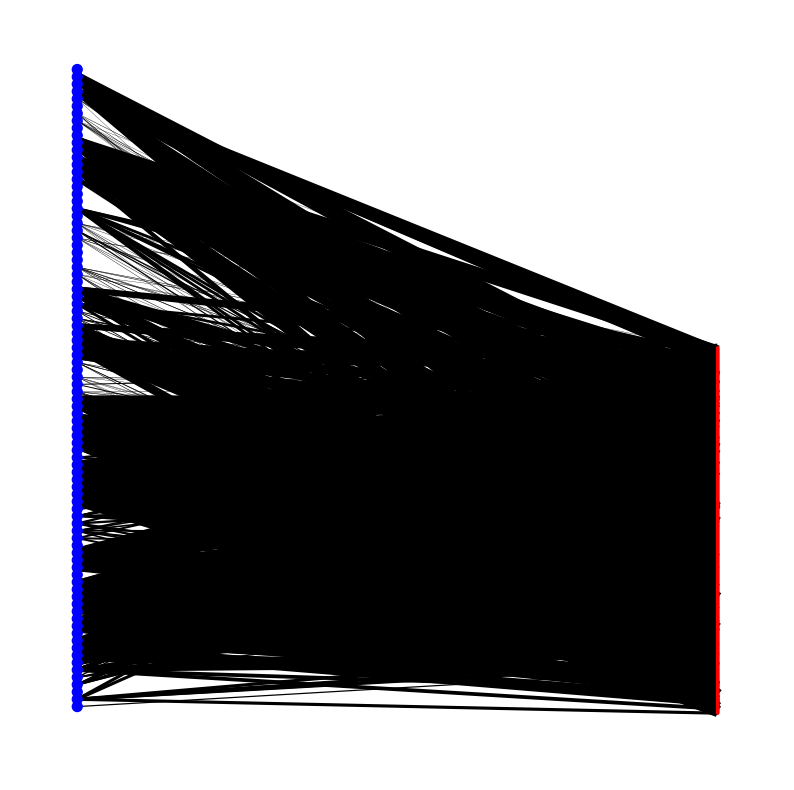

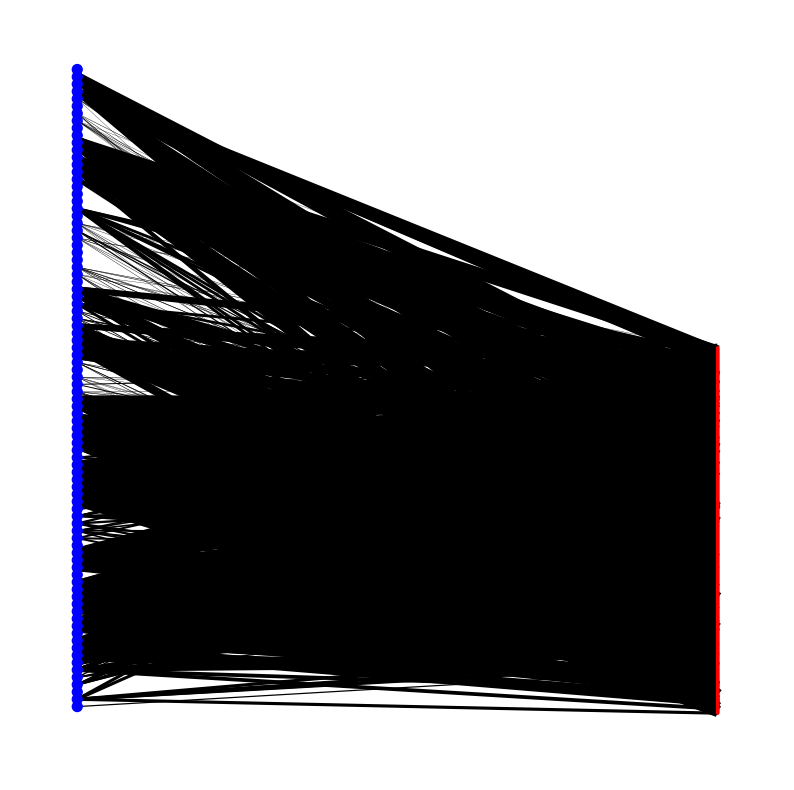

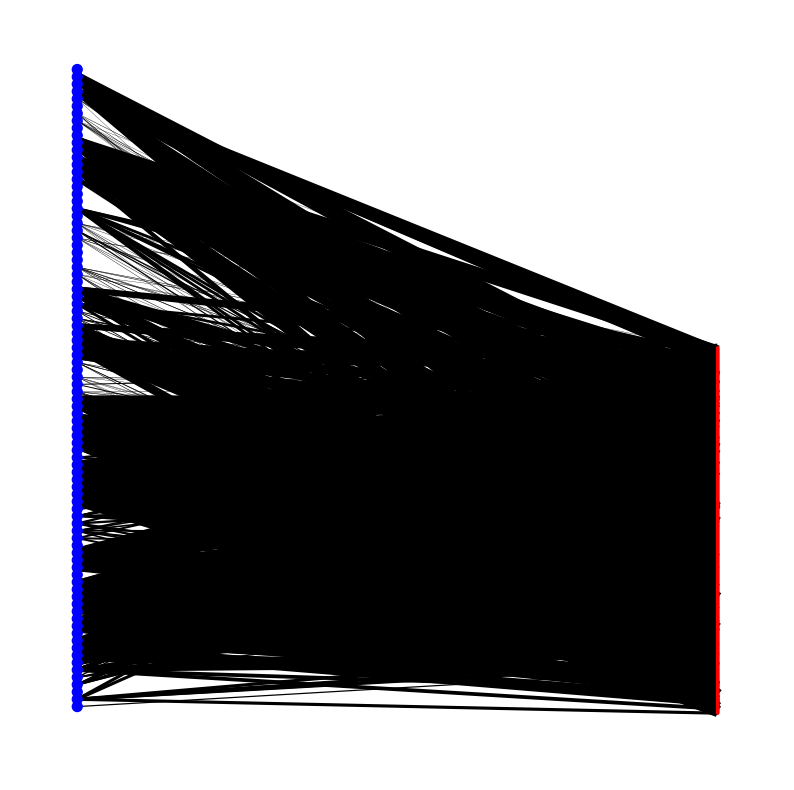

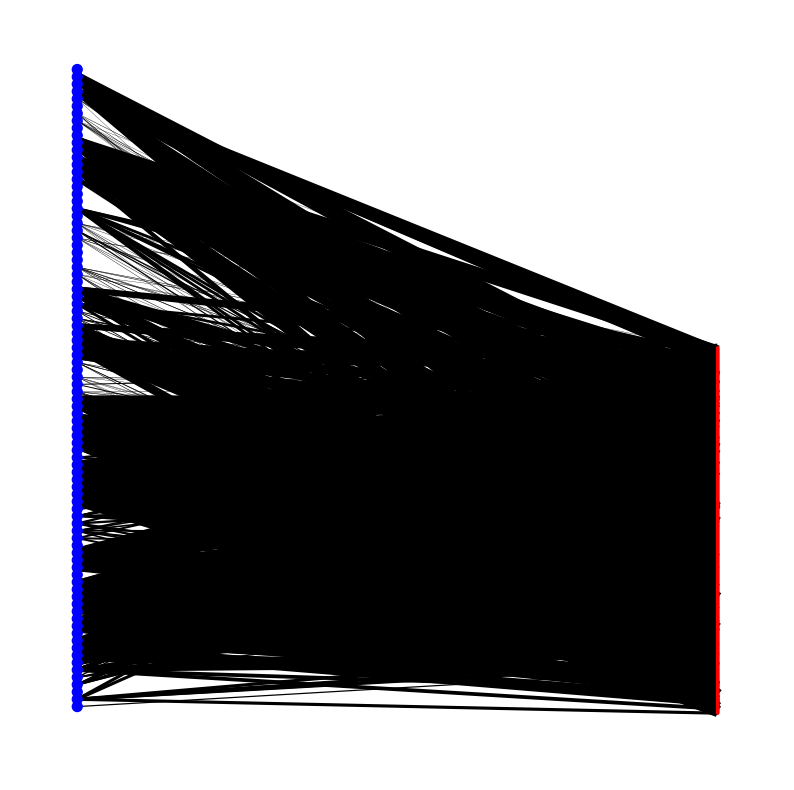

In [4]:
# draw the graph of the last step with  Weight
# remove the nodes with no edges

for i in range(1, len(model.graphs)):
    if i % 100 == 0:
        # model.graphs[i].remove_nodes_from(list(nx.isolates(model.graphs[i])))
        # color the nodes by type
        color_map = []
        node_map = []
        pos = {}
        f = 1
        h = 1
        for node in model.graphs[i]:
            if type(node) is Firm:
                color_map.append('blue')
                node_map.append(50)
                pos[node] = (1, f * 10)
                f += 1
            else:
                color_map.append('red')
                node_map.append(2)
                pos[node] = (2, h)
                h += 1
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        # draw the bipartite graph using the node color map

        nx.draw(model.graphs[i], with_labels=False, width=[model.graphs[i][u][v]['weight'] for u,v in model.graphs[i].edges()], node_color = color_map, node_size = node_map, pos=pos)
        #plt.show()



In [5]:
df = model.datacollector.get_agent_vars_dataframe().reset_index()

In [6]:
# for each Step, computes the HHI for each Firm
df_firm = df.loc[df['Type'] == 'Firm']
# normalize df_firm['Revenue'] in each Step
df_firm['Market_share'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x/x.sum())
# square the Market_share
df_firm['R'] = df_firm['Market_share']**2
# compute the HHI
HHI = df_firm.groupby(['Step'])['R'].sum()

#df_firm['HHI'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x**2).groupby(['Step', 'Type']).transform('sum')



/var/folders/cy/01tnmvcx0_d54pv4f2k6dkv40000gn/T/ipykernel_12572/3487603048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firm['Market_share'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x/x.sum())
/var/folders/cy/01tnmvcx0_d54pv4f2k6dkv40000gn/T/ipykernel_12572/3487603048.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firm['R'] = df_firm['Market_share']**2


/Users/todd/WWCS_2023_markets/env/lib/python3.9/site-packages/scipy/sparse/_base.py:752: VisibleDeprecationWarning: Please use `.todense()` instead
  warn(np.VisibleDeprecationWarning(


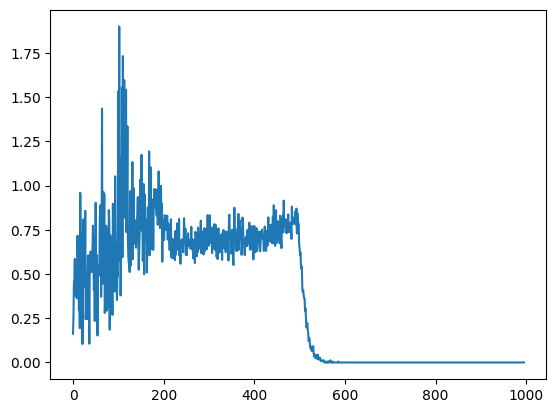

In [7]:
def refresh_graph(graph_a, additions):
    """Ensures that the nodes (and the adjacency lists) are in the right order"""
    out = nx.Graph()
    nodes = list(graph_a.nodes()) + list(additions)
    nodes = sorted(nodes)
    out.add_nodes_from(nodes)
    out.add_edges_from(graph_a.edges())
    return out

def compute_change(graph_a, graph_b):
    additions = graph_b.nodes() - graph_a.nodes() 
    deletions = graph_a.nodes() - graph_b.nodes() 
    graph_a = refresh_graph(graph_a, additions)
    graph_b = refresh_graph(graph_b, deletions)    
    prev = nx.adjacency_matrix(graph_a).A
    curr = nx.adjacency_matrix(graph_b).A
    change = sum(sum(abs(curr - prev)))
    maximum = sum(sum(prev))
    return change / maximum

def change_metric(graphs):
    """
    Takes in a list of transaction graphs and returns a list of the change between each
    """
    output = [0]
    for i in range(0, len(graphs)):
        output.append(compute_change(graphs[i-1], graphs[i]))
    return output

our_metric = change_metric(model.graphs[1:])
our_metric = our_metric[5:]
plt.plot(our_metric)

1.5

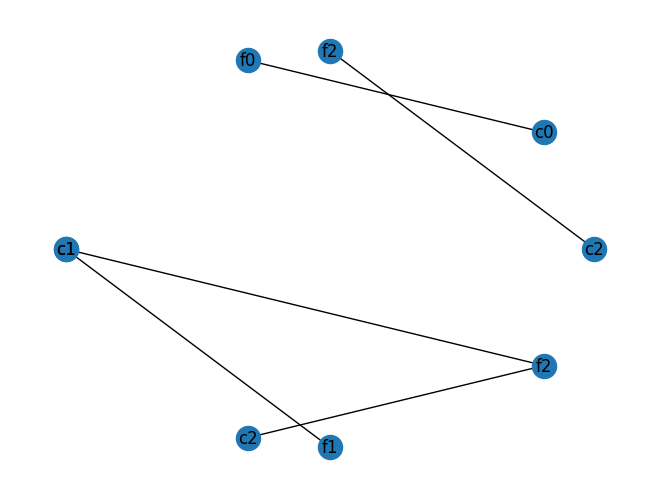

In [8]:
a = nx.Graph()
a.add_edge("c1", "f1", weight=1)
a.add_edge("c2", "f2", weight=1)

b = a.copy()
b.remove_node('f1')
b.add_edge("c1", "f2", weight=1)
b.add_edge("c0", "f0", weight=1)

compute_change(a,b)

<AxesSubplot: xlabel='Step'>

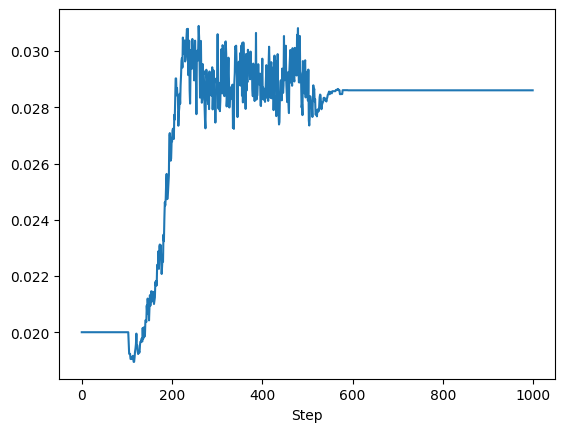

In [9]:
HHI.plot()

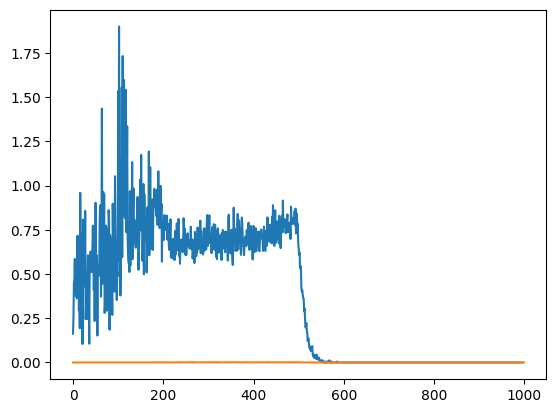

In [10]:
def compute_hhi_diff(hhi):
    hhi_diff = [0]

    for i in range(1, len(hhi)):
        change = abs(hhi[i] - hhi[i-1])
        hhi_diff.append(change)

    return hhi_diff

plt.plot(our_metric)
plt.plot(compute_hhi_diff(HHI))

<AxesSubplot: xlabel='Step', ylabel='budget'>

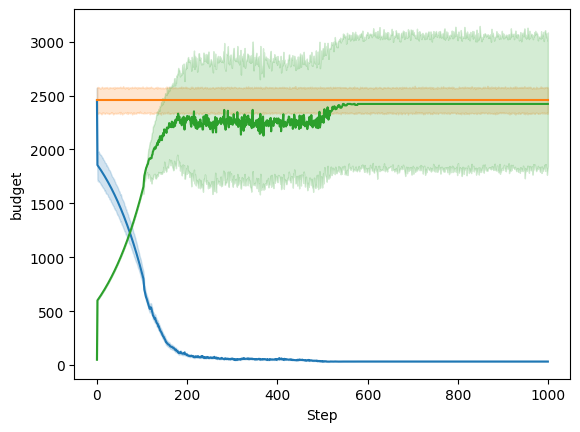

In [11]:
#sns.lineplot(data=df, y='Revenue', x='Step', estimator='sum')
sns.lineplot(data=df, y='budget', x='Step', estimator='sum')
sns.lineplot(data=df, y='Initial_budget', x='Step', estimator='sum')
sns.lineplot(data=df, y='Revenue', x='Step', estimator='sum')


/var/folders/cy/01tnmvcx0_d54pv4f2k6dkv40000gn/T/ipykernel_12572/469125640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firm['number'] = 1


<AxesSubplot: xlabel='Step', ylabel='number'>

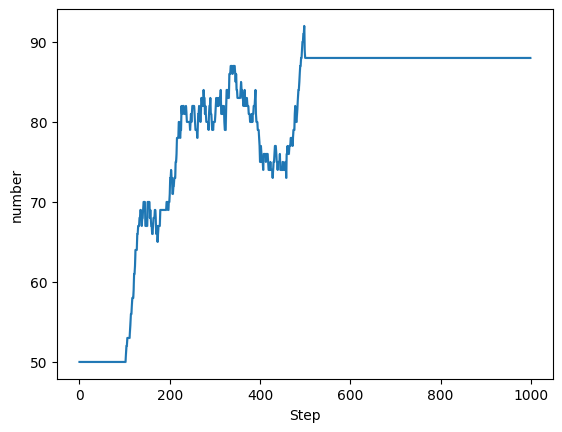

In [12]:
# draw the graph with the number of firms
# count the number of AgentID in each step
df_firm['number'] = 1

sns.lineplot(data=df_firm, x='Step', y='number', estimator='sum')


<AxesSubplot: xlabel='Step', ylabel='Net_worth'>

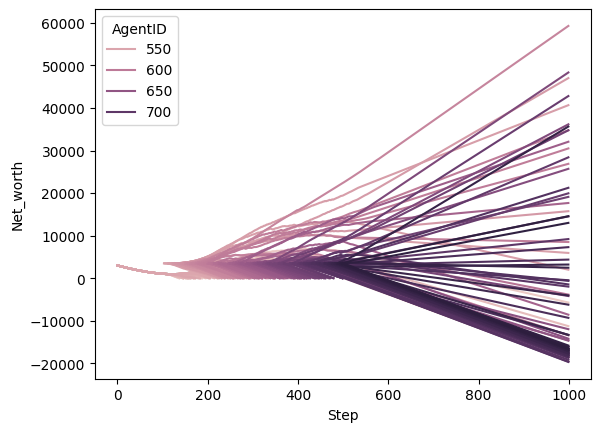

In [13]:
sns.lineplot(data=df_firm, y='Net_worth', x='Step', hue='AgentID')

<AxesSubplot: xlabel='Step', ylabel='Quality'>

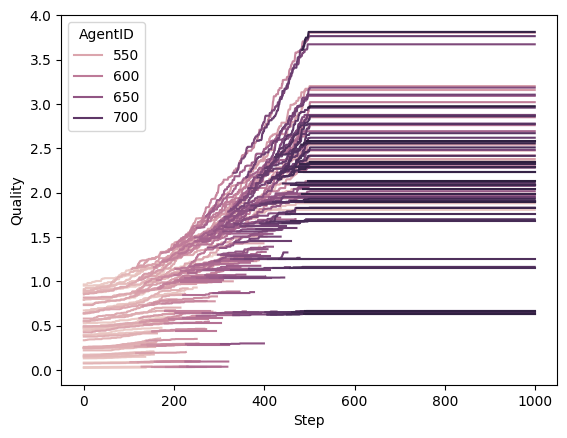

In [14]:
sns.lineplot(data=df_firm, y='Quality', x='Step', hue = 'AgentID')

<AxesSubplot: xlabel='Step', ylabel='Price'>

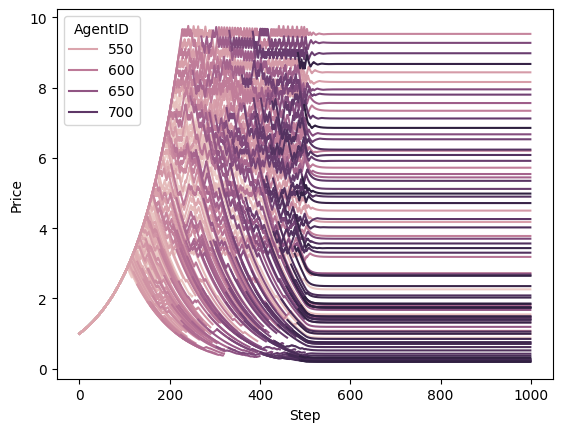

In [15]:
sns.lineplot(data=df_firm, y='Price', x='Step', hue = 'AgentID')

<AxesSubplot: xlabel='Step', ylabel='Quantity_sold'>

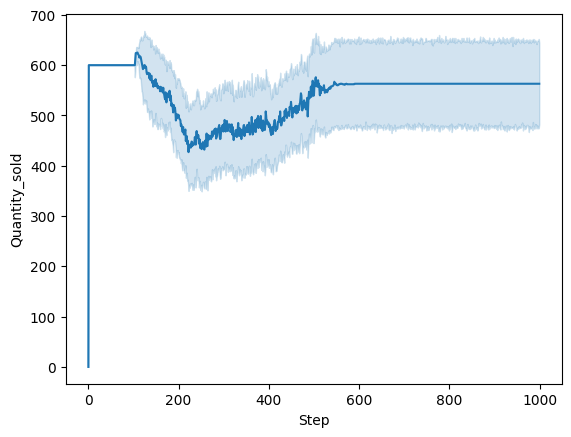

In [16]:
sns.lineplot(data=df, y='Quantity_sold', x='Step', estimator='sum')


<AxesSubplot: xlabel='Step', ylabel='Revenue'>

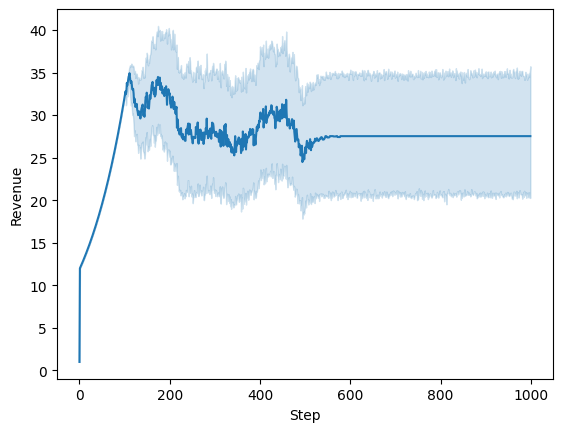

In [17]:
sns.lineplot(data=df, y='Revenue', x='Step')


<AxesSubplot: >

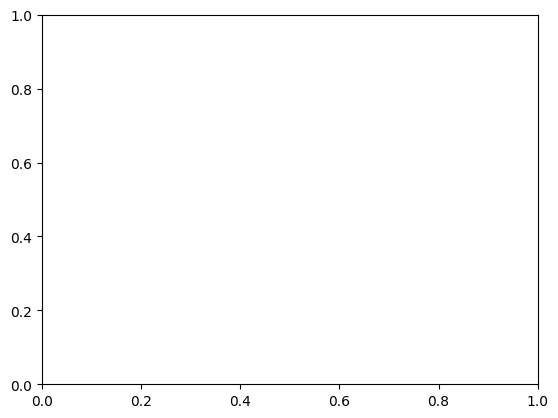

In [18]:
sns.lineplot(data=df.loc[df['AgentID'] == 1020],
             y='Revenue', x='Step', hue='AgentID')


In [19]:
df.loc[(df['Step'] == 0) & (df['Type'] == 'Household')].sort_values('budget')


Step  AgentID       Type  Quality  Revenue  Quantity_sold  Price  \
18      0       19  Household      NaN      NaN            NaN    NaN   
354     0      355  Household      NaN      NaN            NaN    NaN   
349     0      350  Household      NaN      NaN            NaN    NaN   
281     0      282  Household      NaN      NaN            NaN    NaN   
167     0      168  Household      NaN      NaN            NaN    NaN   
..    ...      ...        ...      ...      ...            ...    ...   
30      0       31  Household      NaN      NaN            NaN    NaN   
84      0       85  Household      NaN      NaN            NaN    NaN   
427     0      428  Household      NaN      NaN            NaN    NaN   
181     0      182  Household      NaN      NaN            NaN    NaN   
246     0      247  Household      NaN      NaN            NaN    NaN   

     Net_worth  Initial_budget    budget  
18         NaN        0.011148  0.011148  
354        NaN        0.028864  0.028864  
349        NaN        0.036597  0.036597  
281        NaN        0.084129  0.084129  
167        NaN        0.099988  0.099988  
..         ...             ...       ...  
30         NaN        9.800022  9.800022  
84         NaN        9.929007  9.929007  
427        NaN        9.933342  9.933342  
181        NaN        9.944224  9.944224  
246        NaN        9.945892  9.945892  

[500 rows x 10 columns]

In [20]:
df.loc[(df['Step'] == 0) & (df['Type'] == 'Firm')].sort_values('Quality')


Step  AgentID  Type   Quality  Revenue  Quantity_sold  Price  Net_worth  \
506     0      507  Firm  0.025143      1.0            0.0    1.0     3000.0   
512     0      513  Firm  0.033766      1.0            0.0    1.0     3000.0   
532     0      533  Firm  0.075702      1.0            0.0    1.0     3000.0   
502     0      503  Firm  0.086073      1.0            0.0    1.0     3000.0   
514     0      515  Firm  0.133372      1.0            0.0    1.0     3000.0   
527     0      528  Firm  0.151415      1.0            0.0    1.0     3000.0   
521     0      522  Firm  0.152895      1.0            0.0    1.0     3000.0   
531     0      532  Firm  0.162468      1.0            0.0    1.0     3000.0   
522     0      523  Firm  0.174223      1.0            0.0    1.0     3000.0   
528     0      529  Firm  0.223083      1.0            0.0    1.0     3000.0   
537     0      538  Firm  0.247339      1.0            0.0    1.0     3000.0   
540     0      541  Firm  0.248045      1.0            0.0    1.0     3000.0   
525     0      526  Firm  0.249476      1.0            0.0    1.0     3000.0   
519     0      520  Firm  0.250728      1.0            0.0    1.0     3000.0   
534     0      535  Firm  0.251706      1.0            0.0    1.0     3000.0   
505     0      506  Firm  0.253418      1.0            0.0    1.0     3000.0   
541     0      542  Firm  0.262230      1.0            0.0    1.0     3000.0   
533     0      534  Firm  0.337217      1.0            0.0    1.0     3000.0   
536     0      537  Firm  0.378391      1.0            0.0    1.0     3000.0   
517     0      518  Firm  0.395626      1.0            0.0    1.0     3000.0   
507     0      508  Firm  0.397667      1.0            0.0    1.0     3000.0   
549     0      550  Firm  0.426552      1.0            0.0    1.0     3000.0   
520     0      521  Firm  0.444984      1.0            0.0    1.0     3000.0   
503     0      504  Firm  0.461125      1.0            0.0    1.0     3000.0   
510     0      511  Firm  0.469733      1.0            0.0    1.0     3000.0   
515     0      516  Firm  0.477196      1.0            0.0    1.0     3000.0   
511     0      512  Firm  0.482762      1.0            0.0    1.0     3000.0   
539     0      540  Firm  0.492591      1.0            0.0    1.0     3000.0   
543     0      544  Firm  0.494797      1.0            0.0    1.0     3000.0   
508     0      509  Firm  0.528104      1.0            0.0    1.0     3000.0   
538     0      539  Firm  0.550352      1.0            0.0    1.0     3000.0   
542     0      543  Firm  0.553924      1.0            0.0    1.0     3000.0   
544     0      545  Firm  0.581362      1.0            0.0    1.0     3000.0   
516     0      517  Firm  0.636573      1.0            0.0    1.0     3000.0   
548     0      549  Firm  0.641501      1.0            0.0    1.0     3000.0   
535     0      536  Firm  0.642150      1.0            0.0    1.0     3000.0   
513     0      514  Firm  0.673203      1.0            0.0    1.0     3000.0   
546     0      547  Firm  0.733964      1.0            0.0    1.0     3000.0   
501     0      502  Firm  0.745500      1.0            0.0    1.0     3000.0   
524     0      525  Firm  0.791548      1.0            0.0    1.0     3000.0   
526     0      527  Firm  0.796170      1.0            0.0    1.0     3000.0   
547     0      548  Firm  0.818967      1.0            0.0    1.0     3000.0   
545     0      546  Firm  0.853391      1.0            0.0    1.0     3000.0   
530     0      531  Firm  0.871134      1.0            0.0    1.0     3000.0   
500     0      501  Firm  0.871673      1.0            0.0    1.0     3000.0   
523     0      524  Firm  0.889928      1.0            0.0    1.0     3000.0   
529     0      530  Firm  0.898403      1.0            0.0    1.0     3000.0   
518     0      519  Firm  0.914026      1.0            0.0    1.0     3000.0   
509     0      510  Firm  0.953128      1.0            0.0    1.0     3000.0   
504  

<AxesSubplot: xlabel='AgentID', ylabel='Quality'>

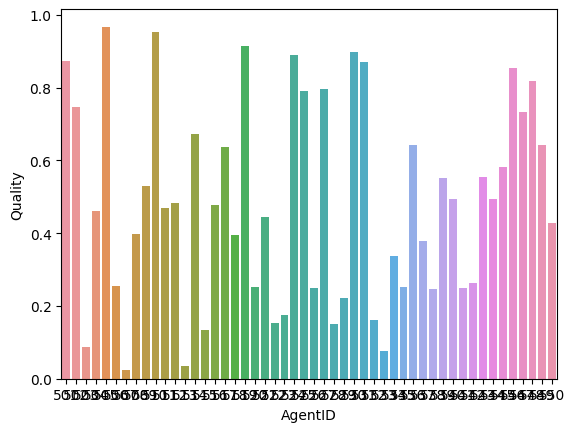

In [21]:
sns.barplot(data=df.loc[(df['Step'] == 0) & (
    df['Type'] == 'Firm')], y='Quality', x='AgentID')


In [22]:
df.loc[df['AgentID'] == 1009]


Empty DataFrame
Columns: [Step, AgentID, Type, Quality, Revenue, Quantity_sold, Price, Net_worth, Initial_budget, budget]
Index: []

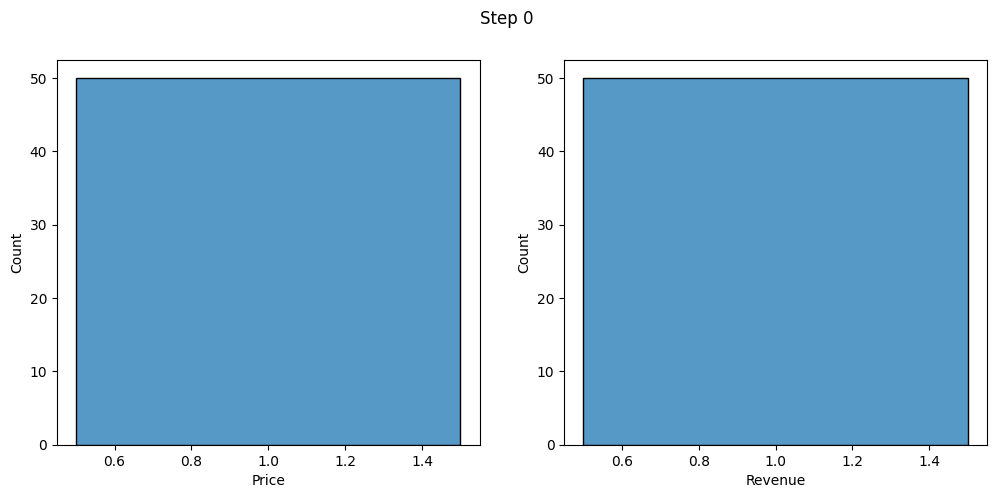

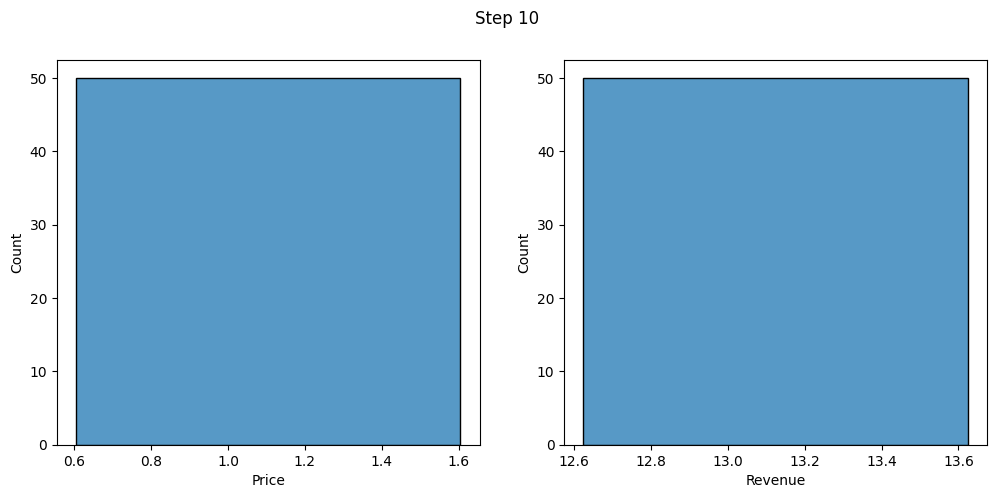

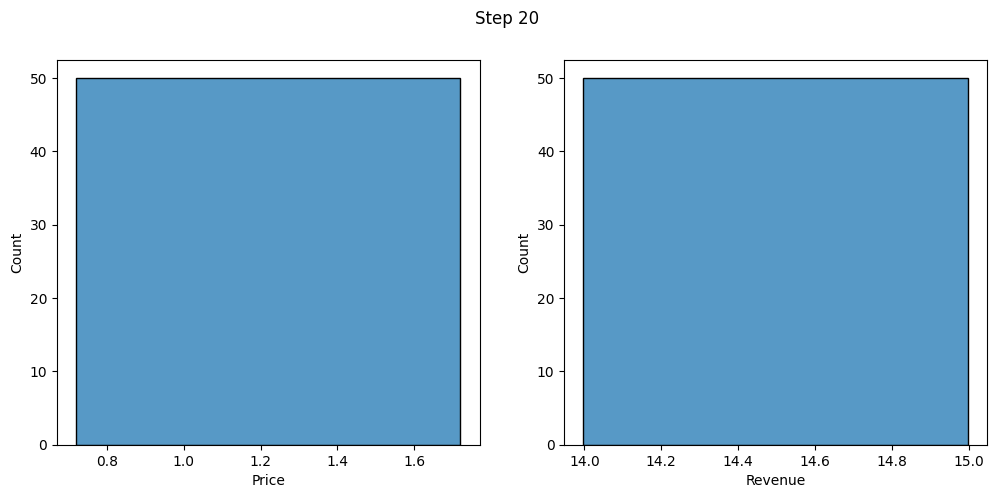

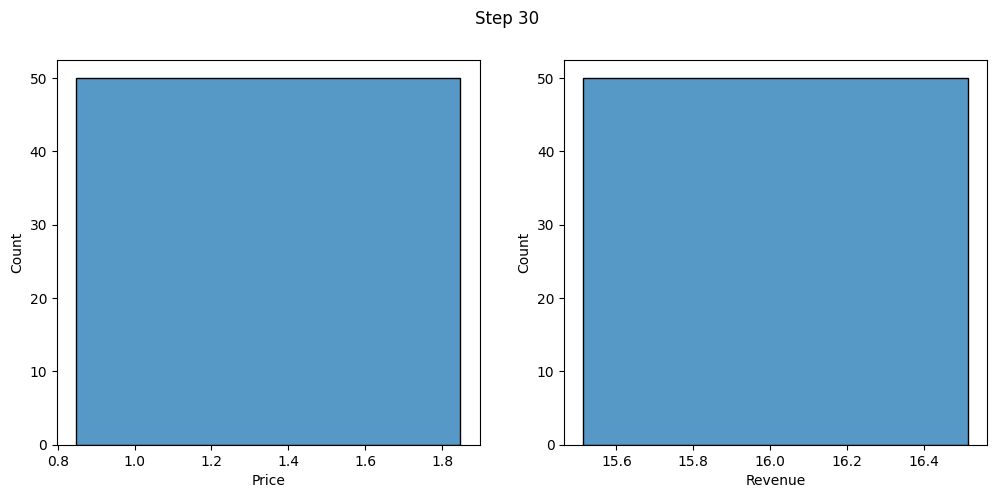

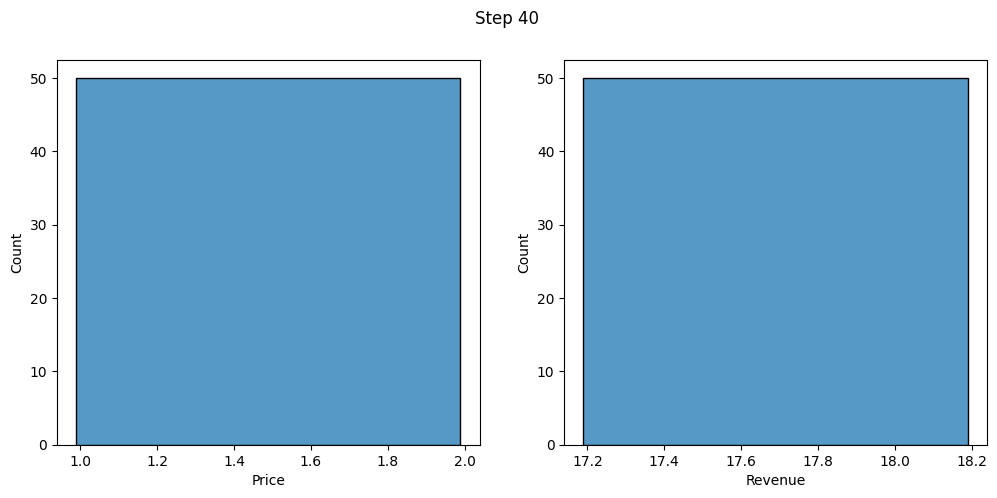

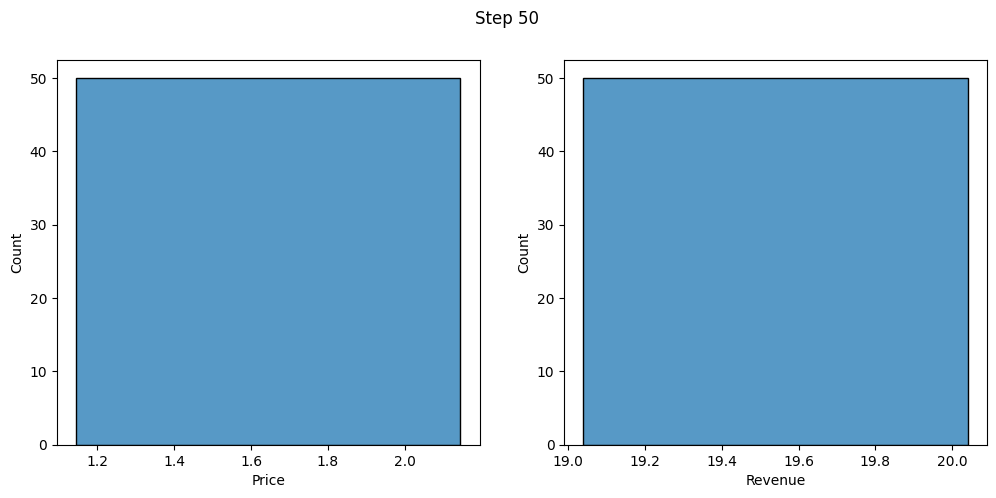

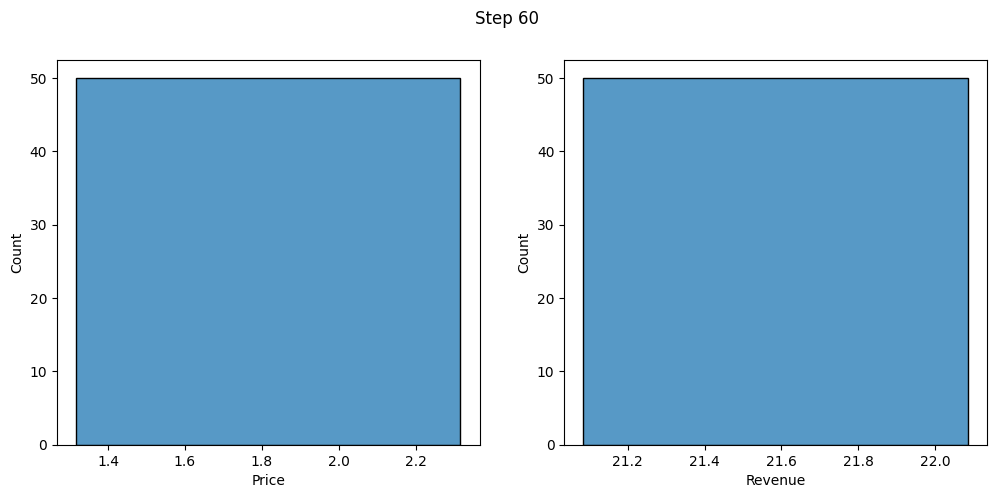

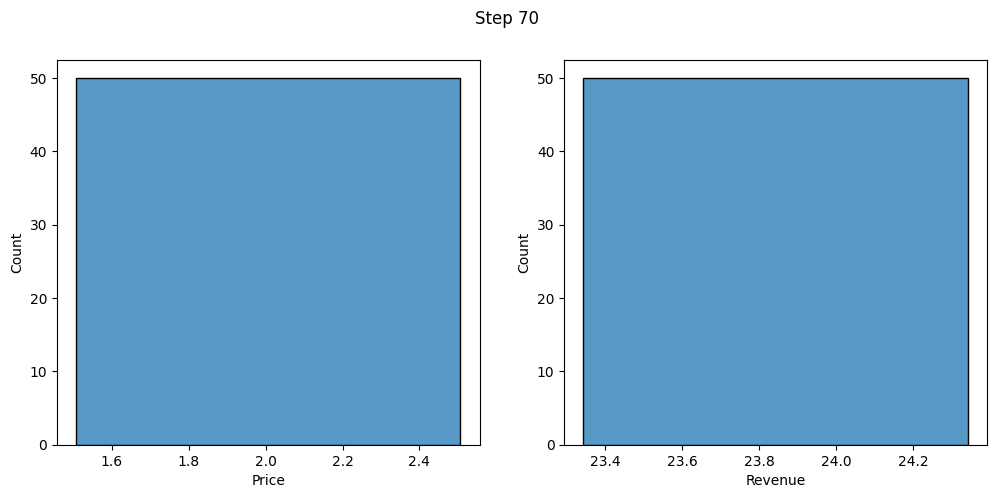

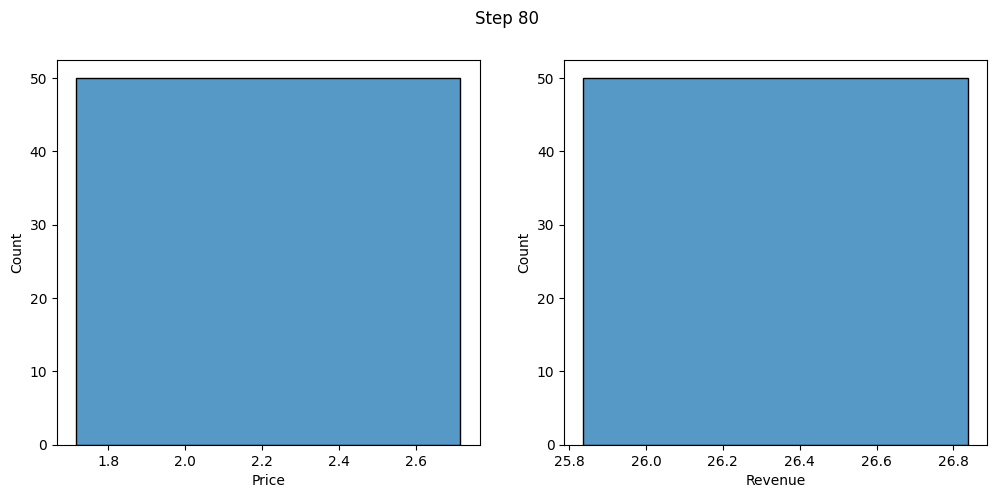

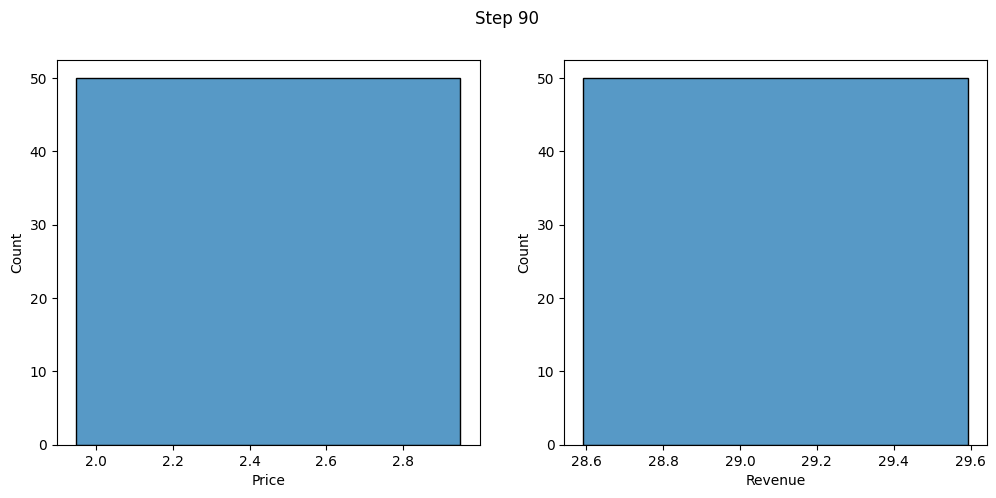

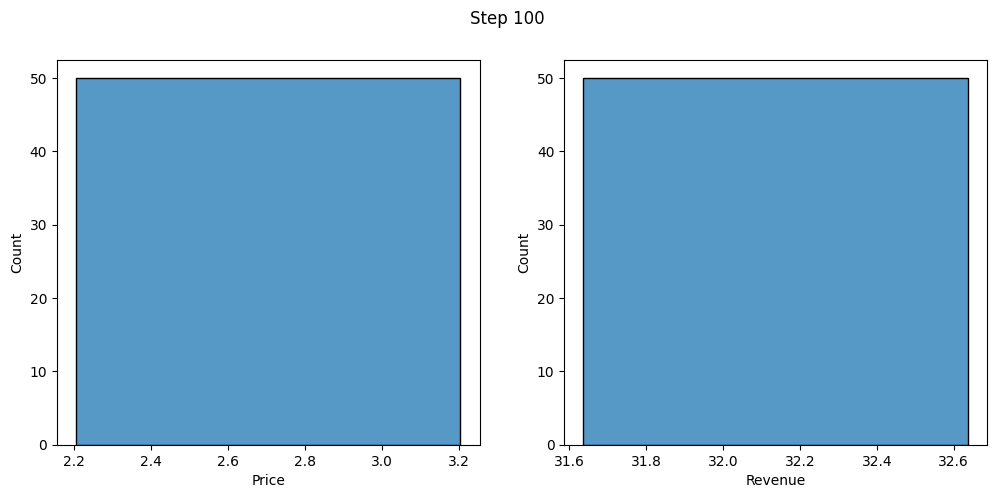

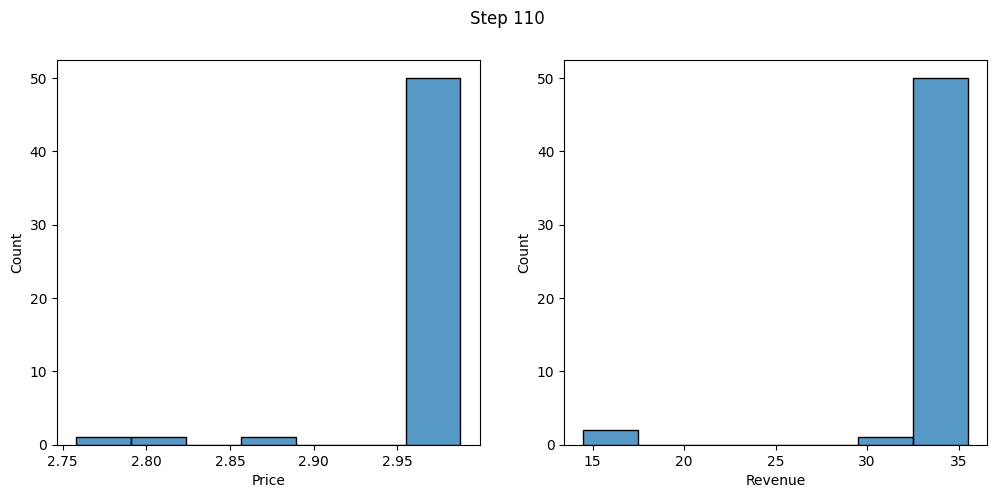

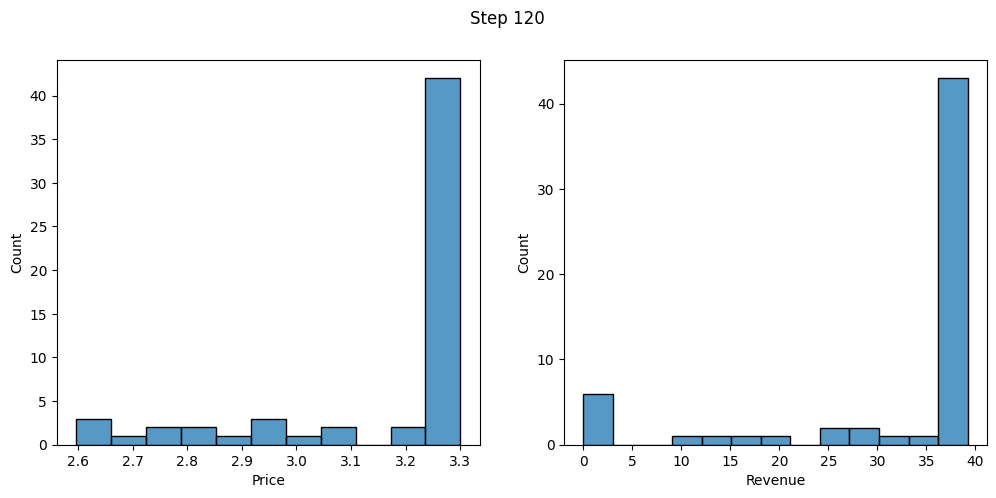

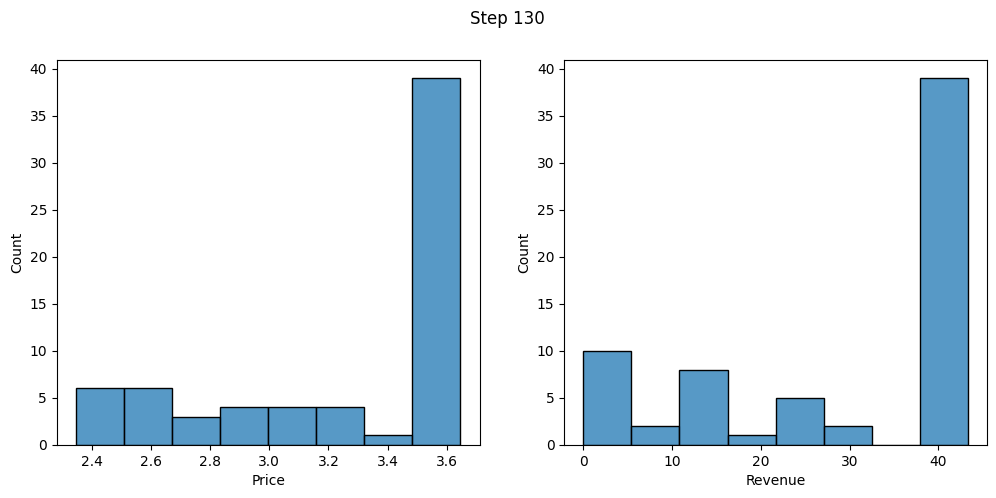

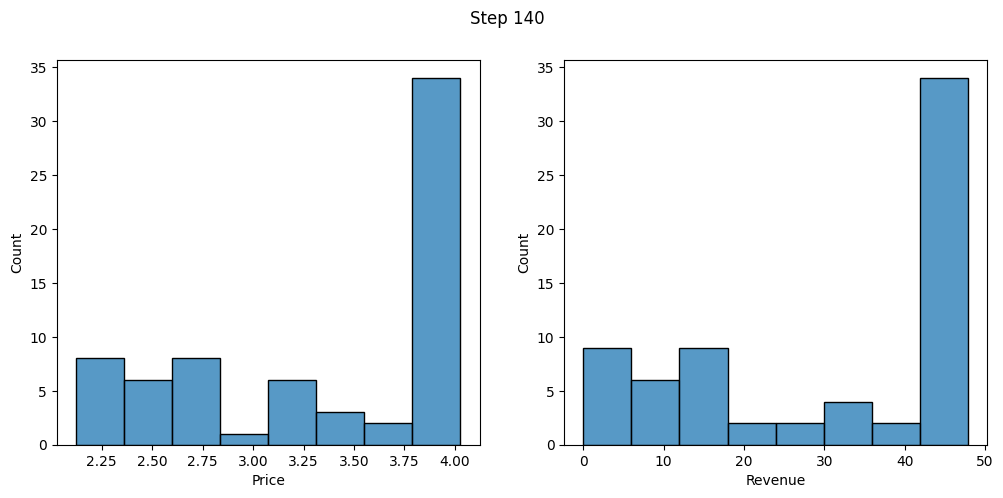

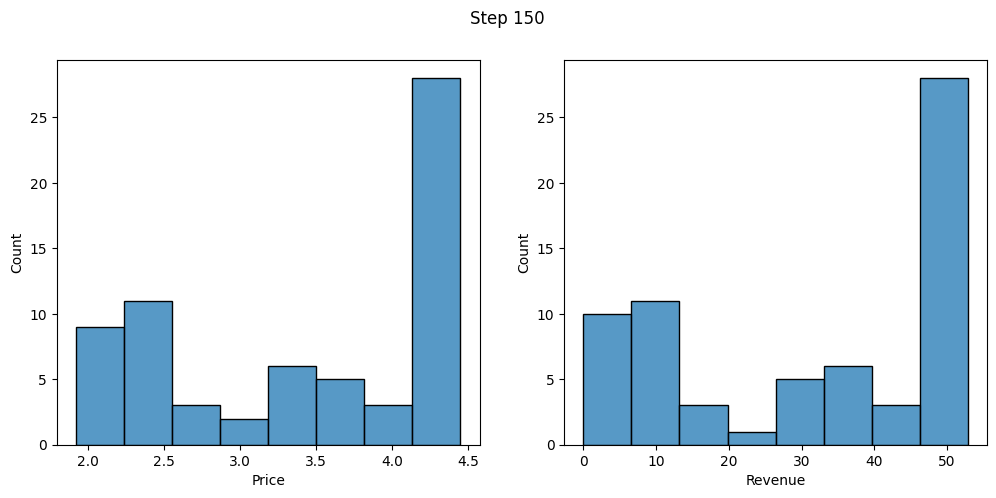

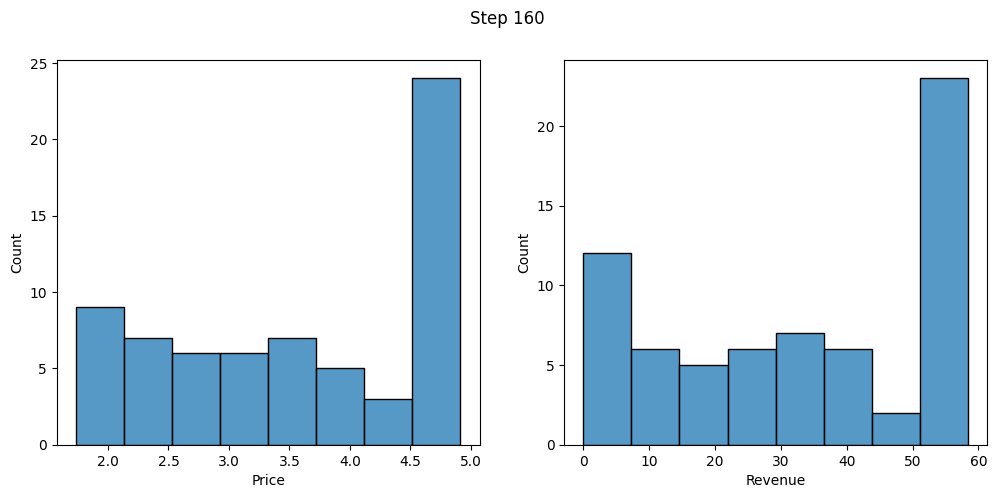

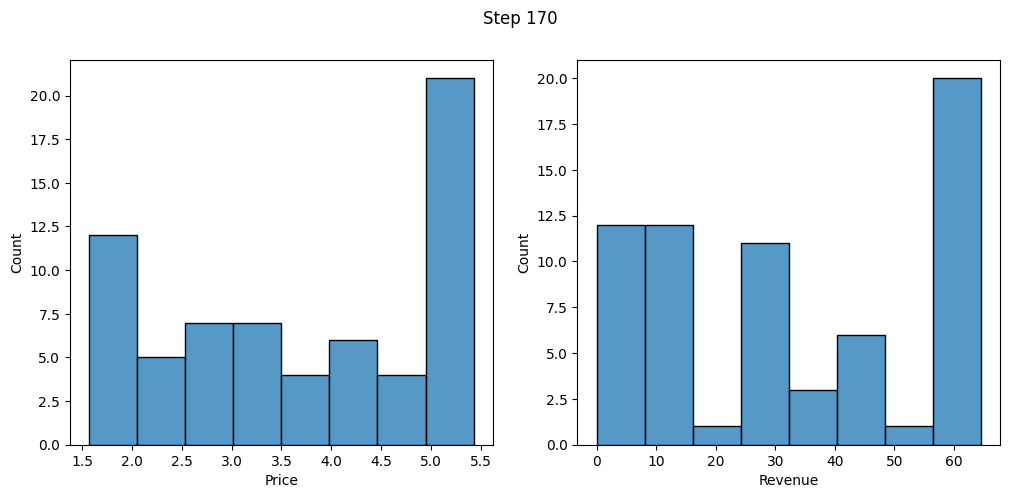

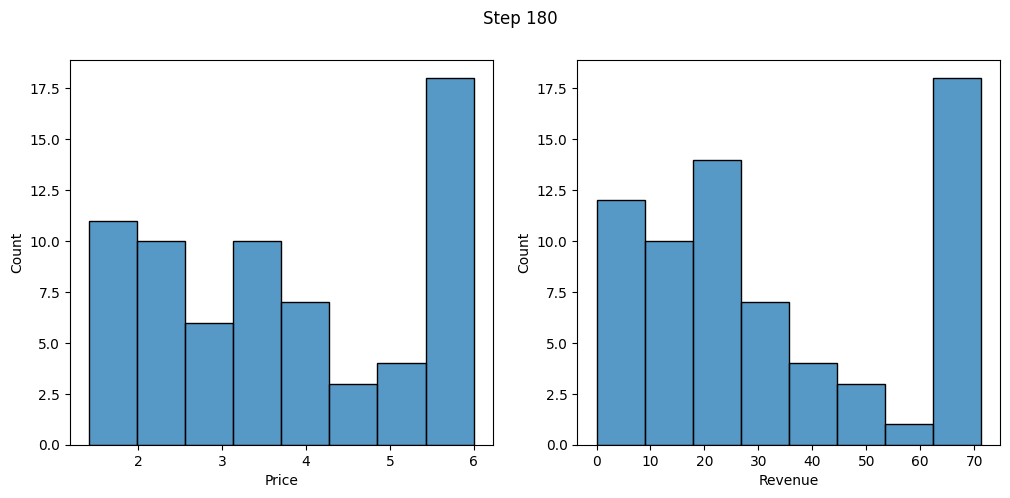

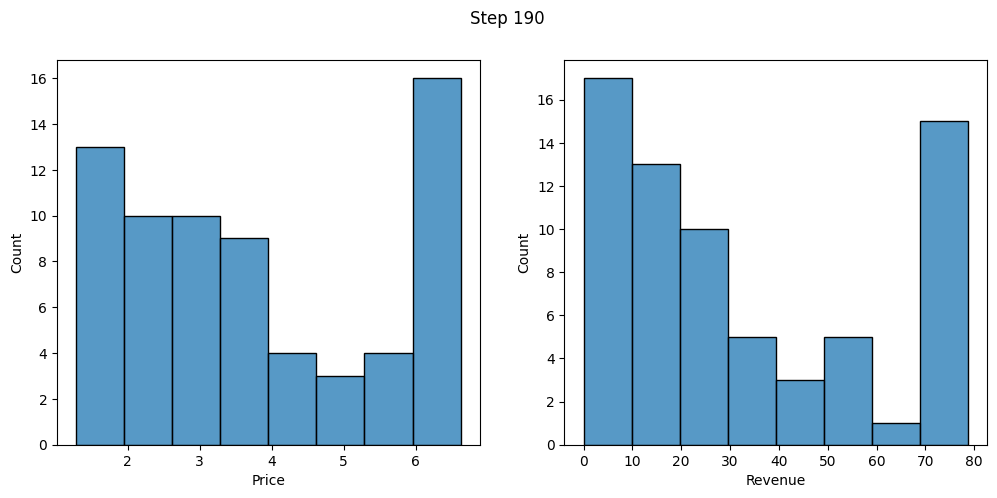

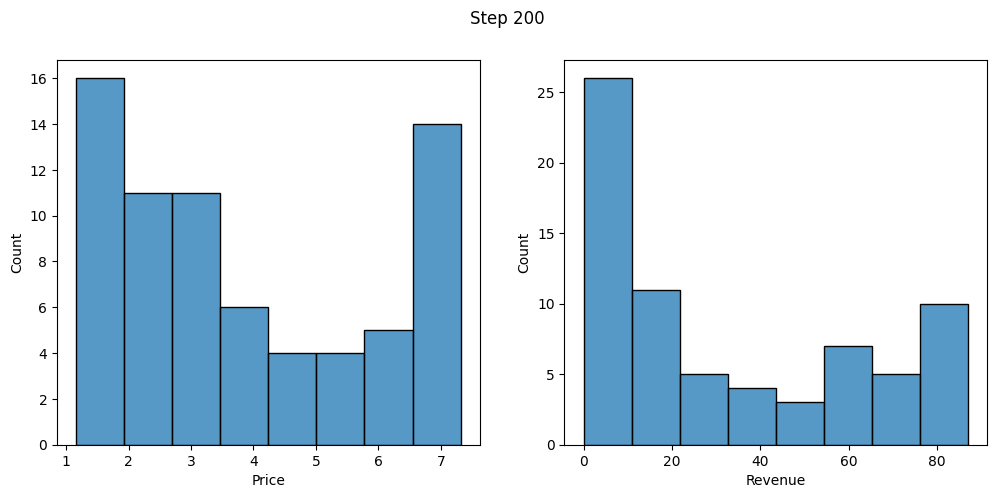

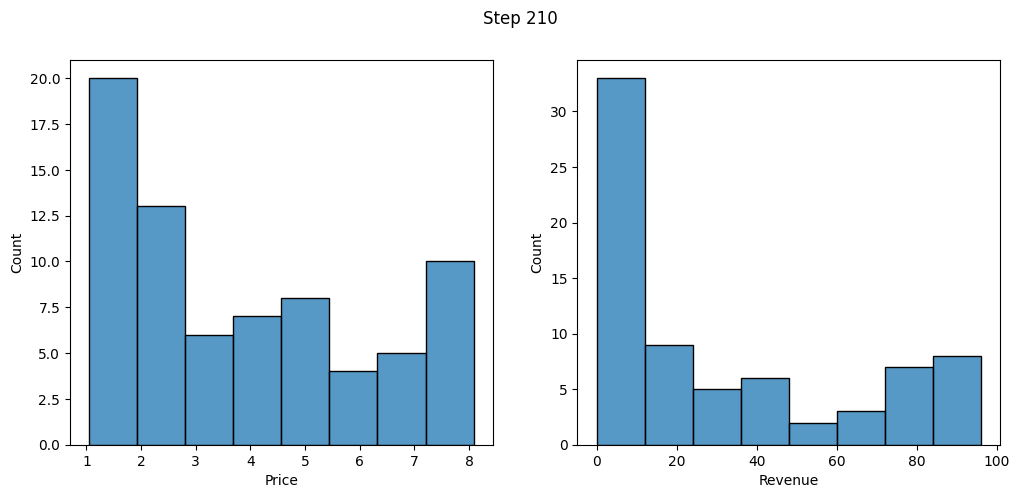

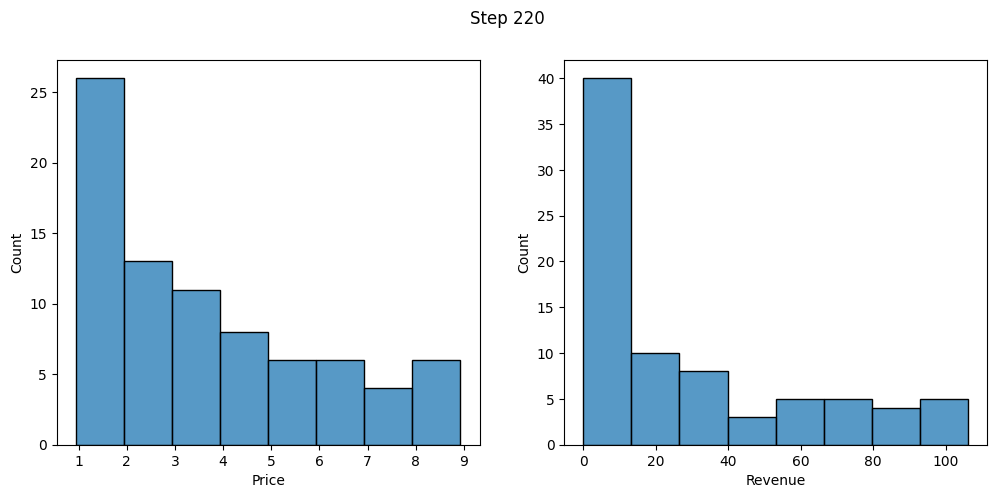

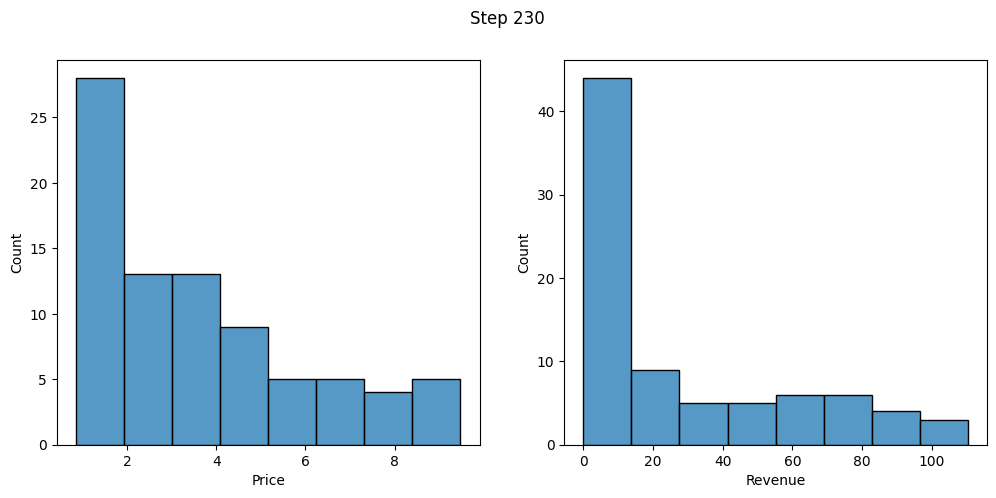

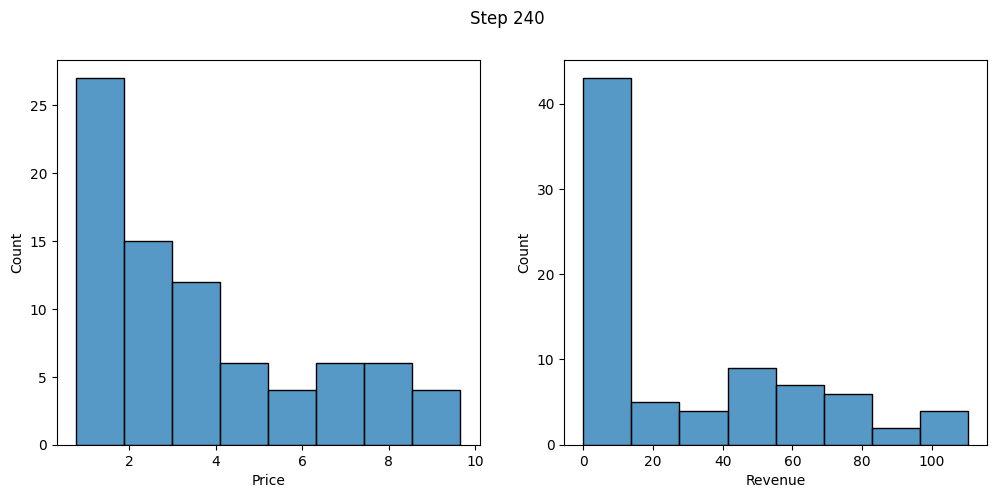

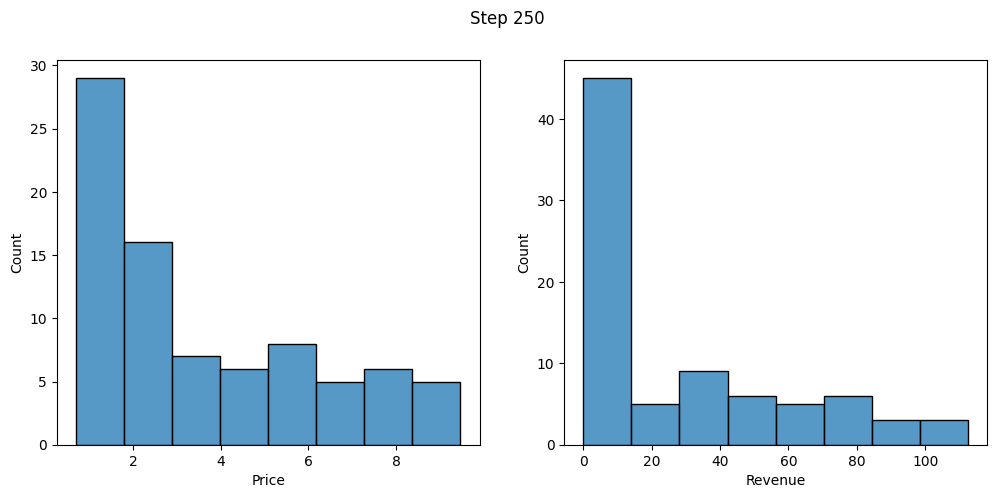

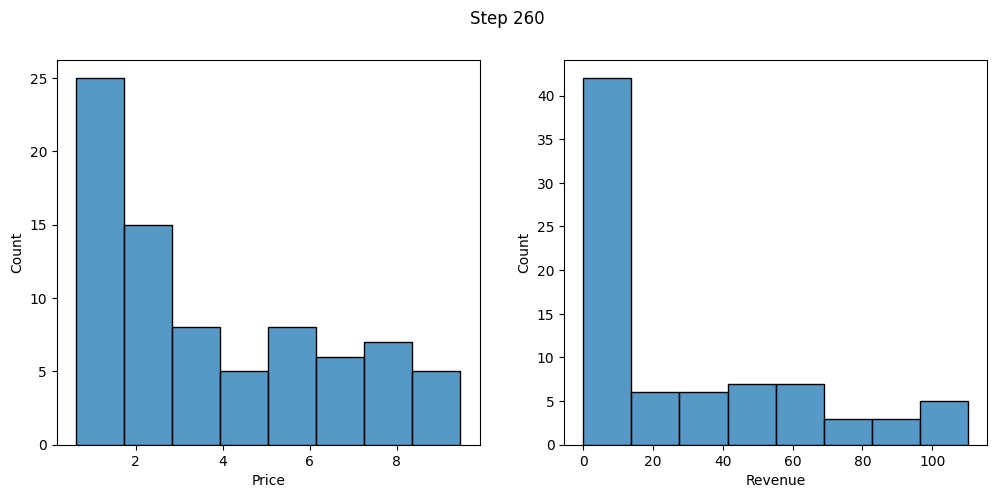

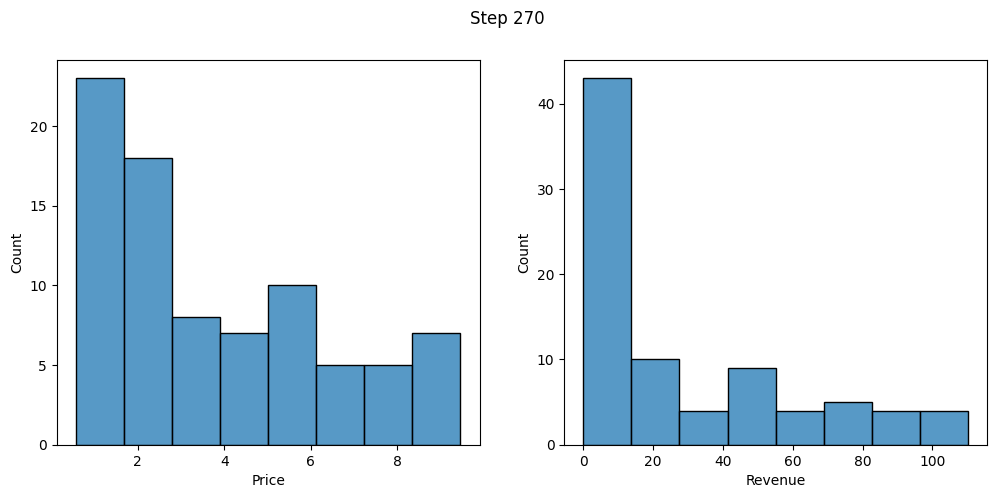

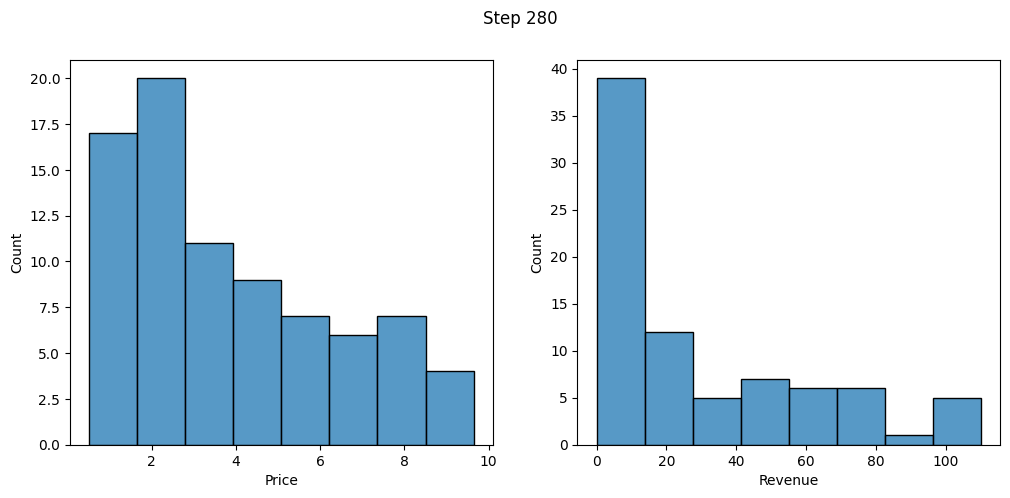

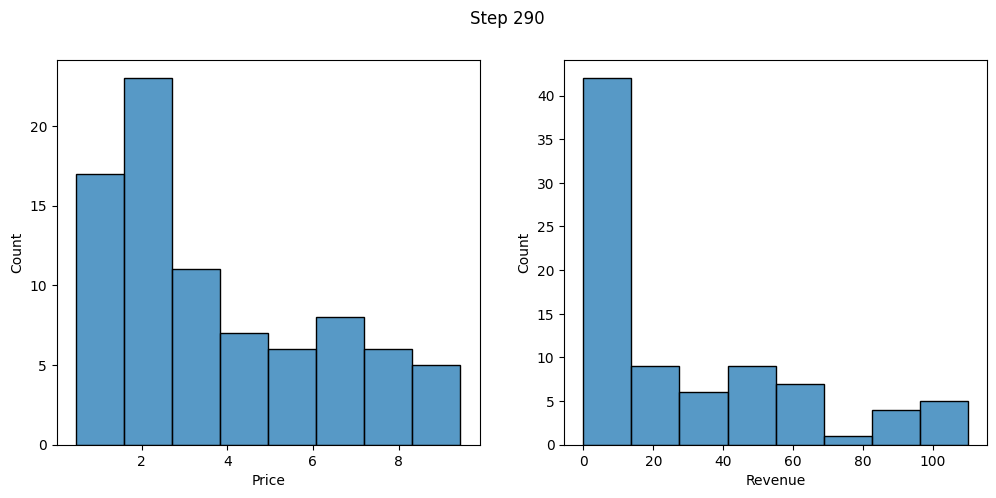

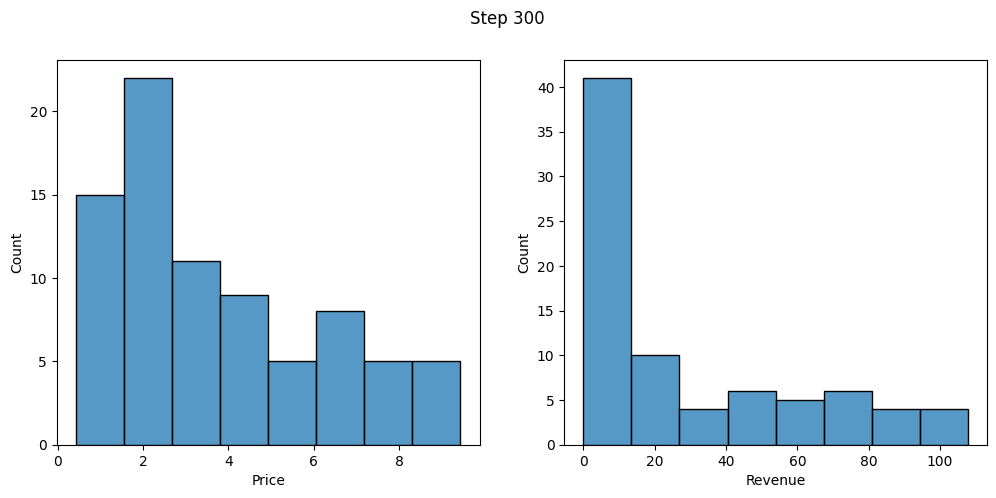

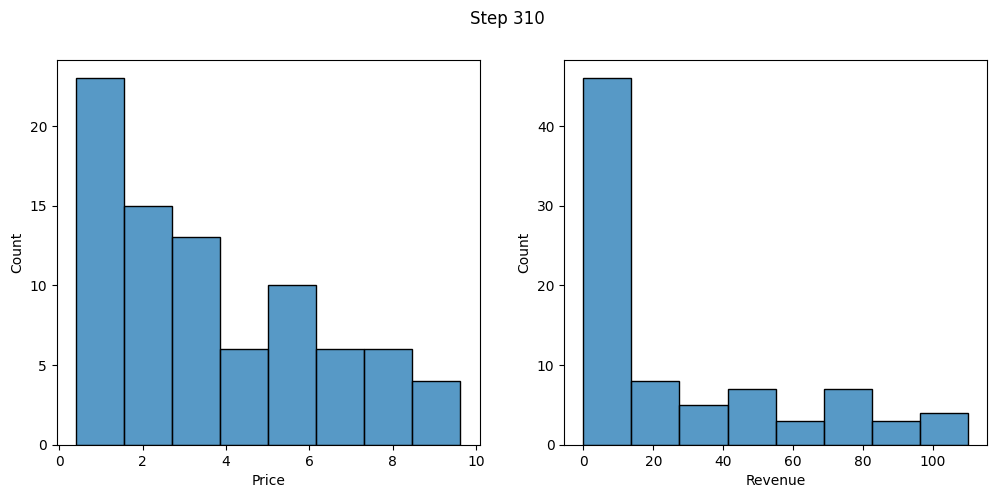

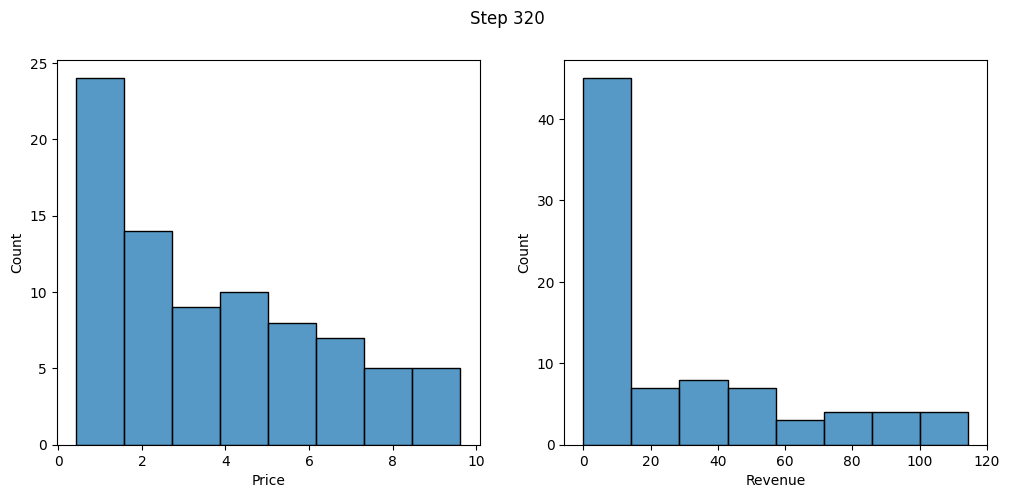

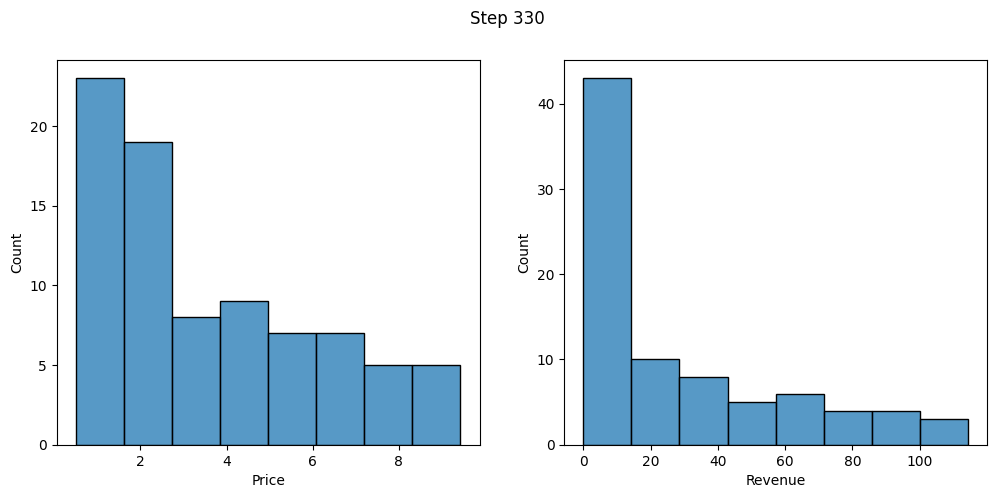

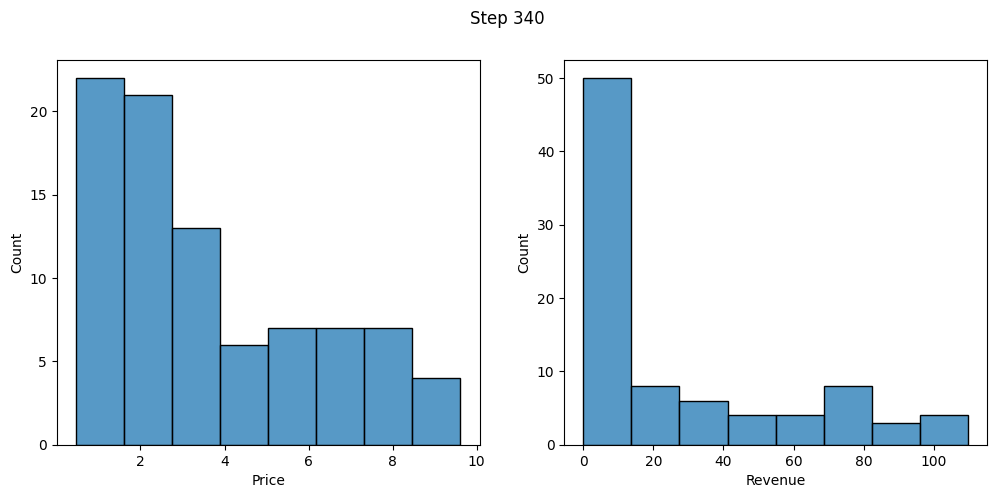

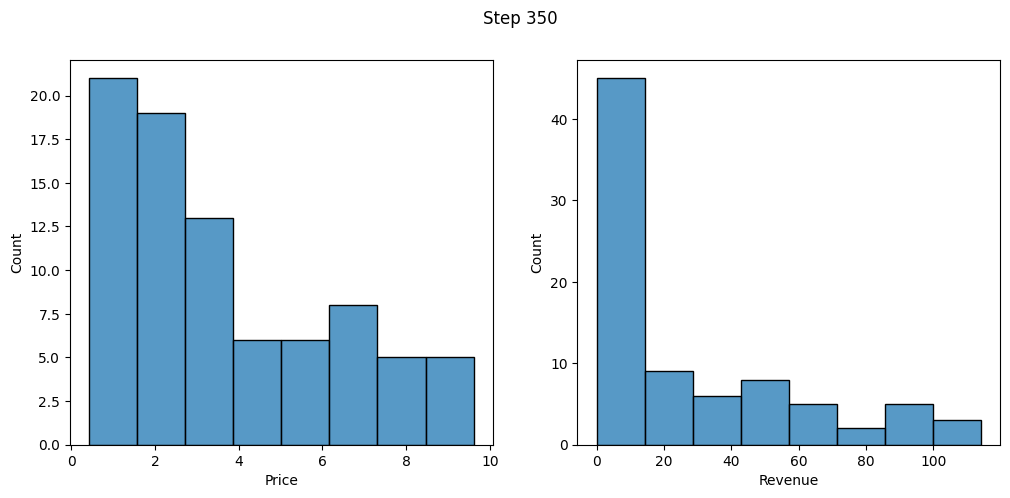

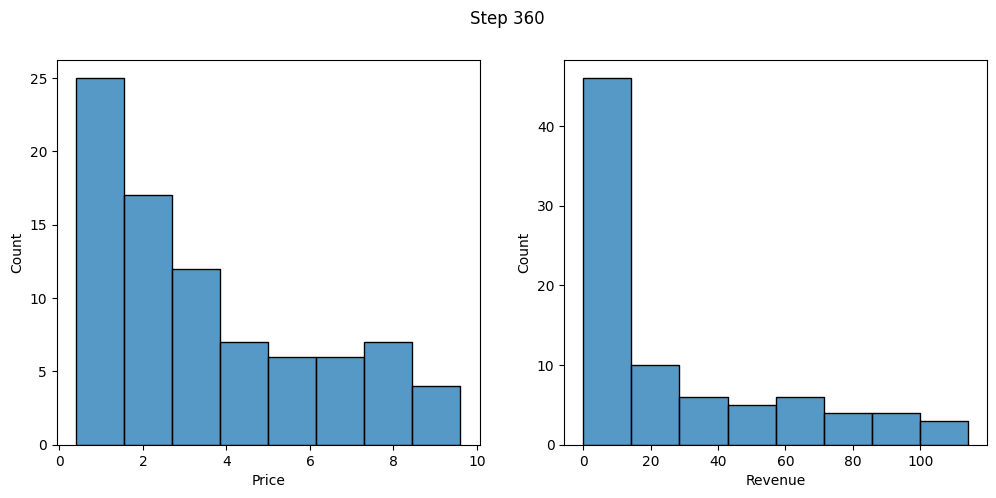

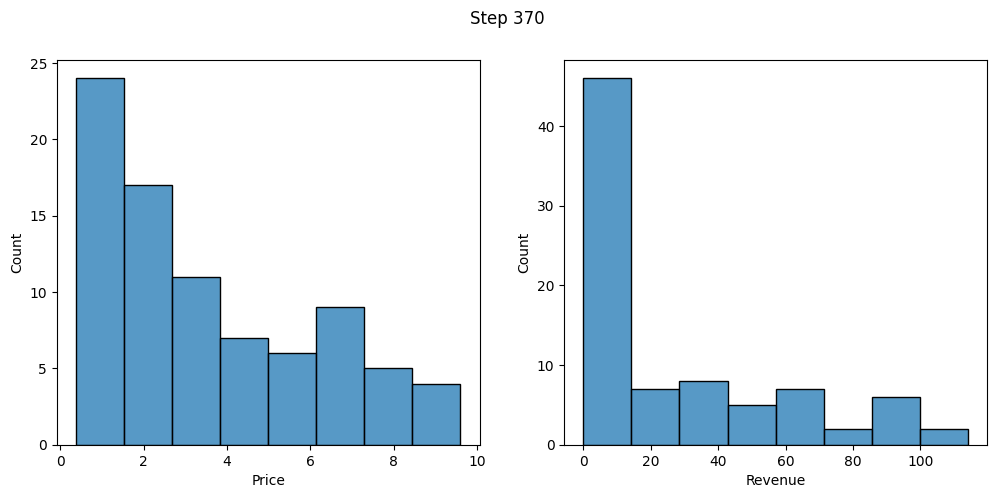

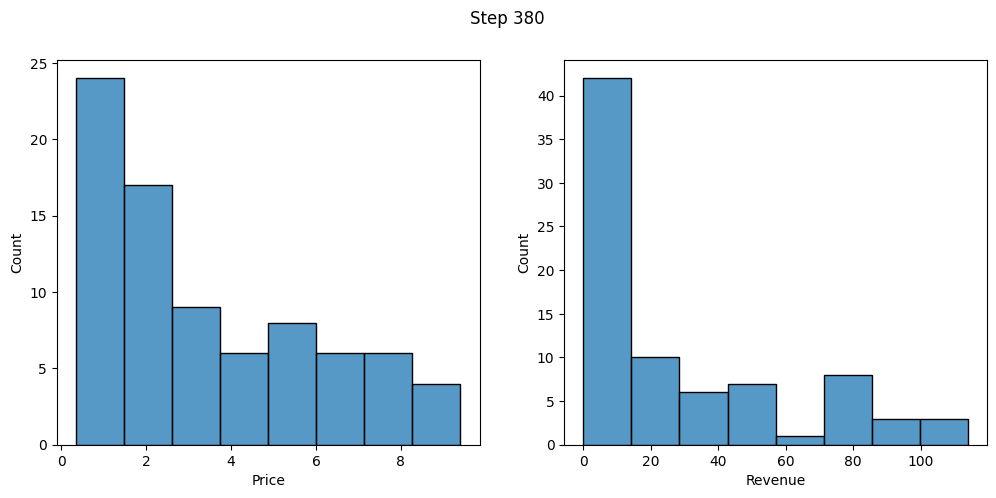

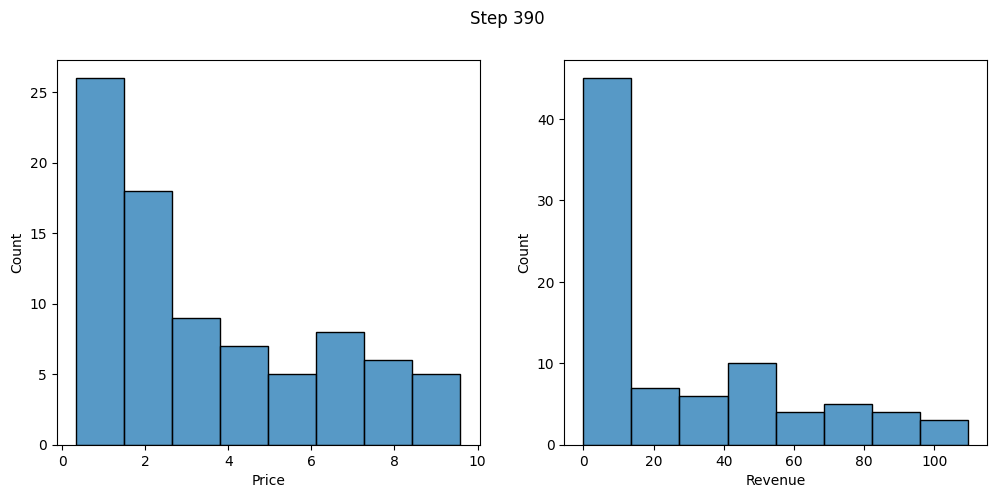

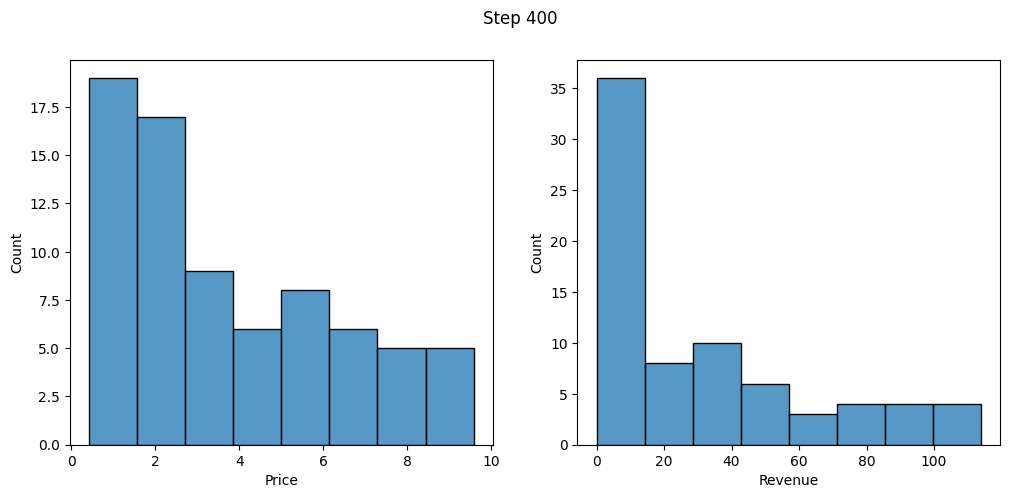

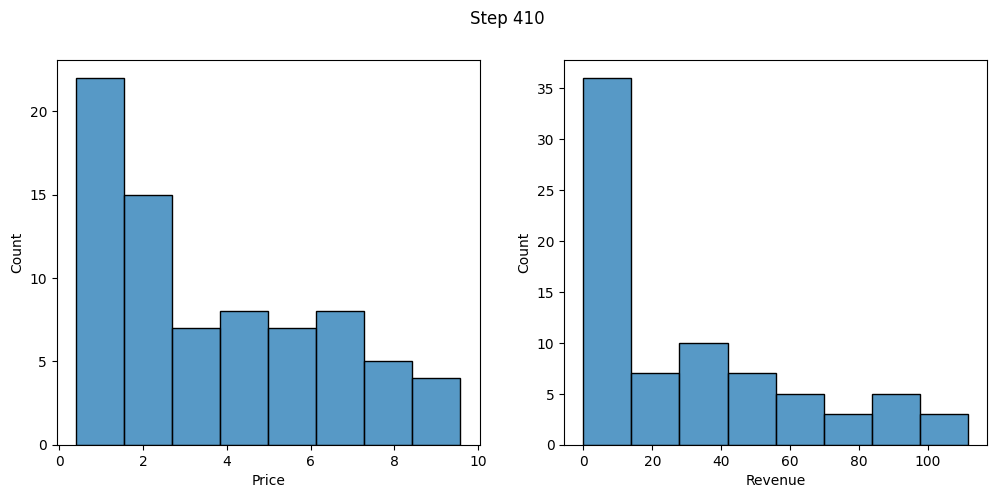

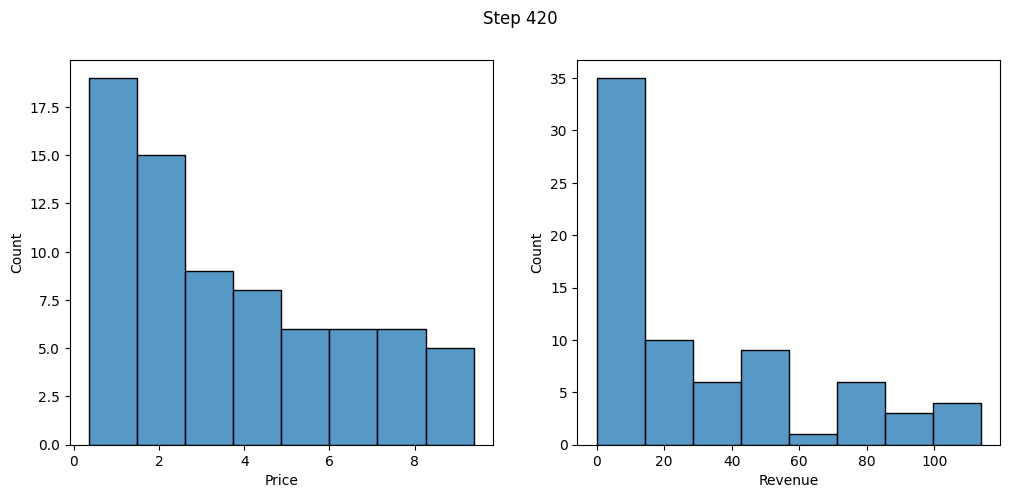

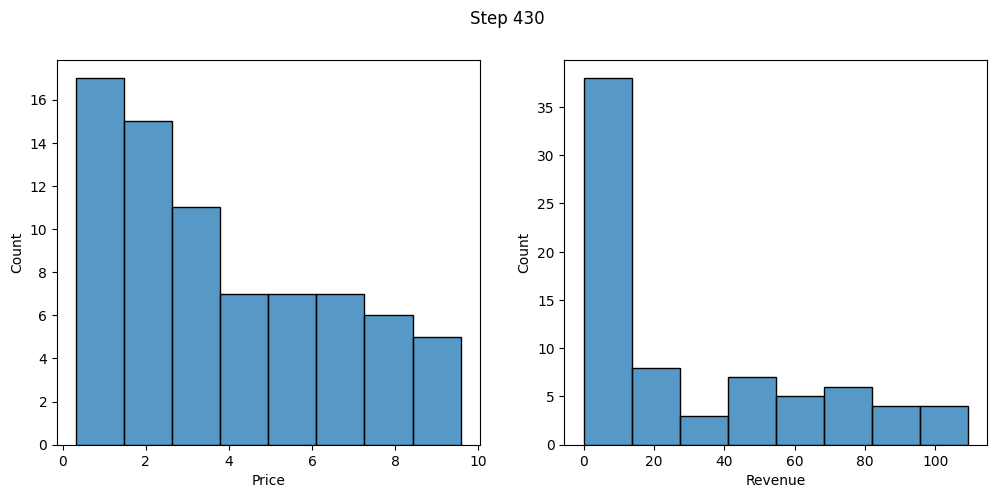

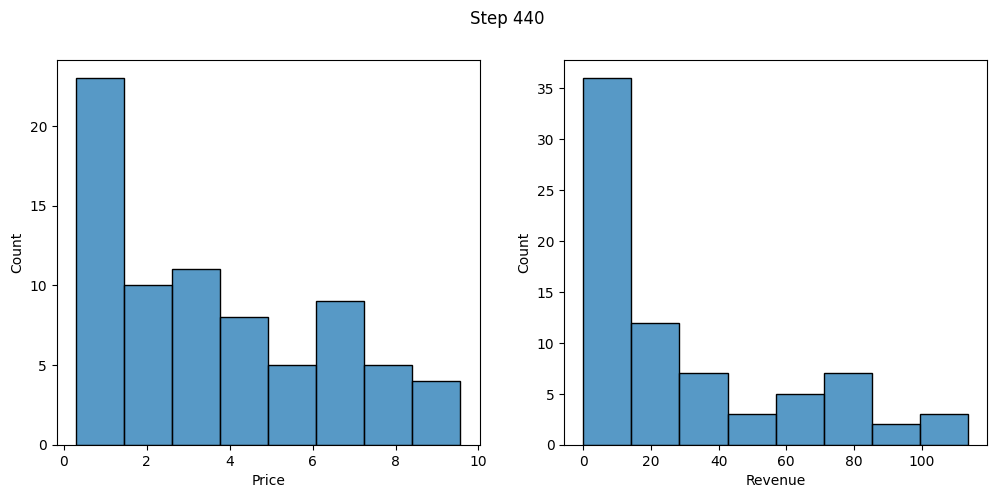

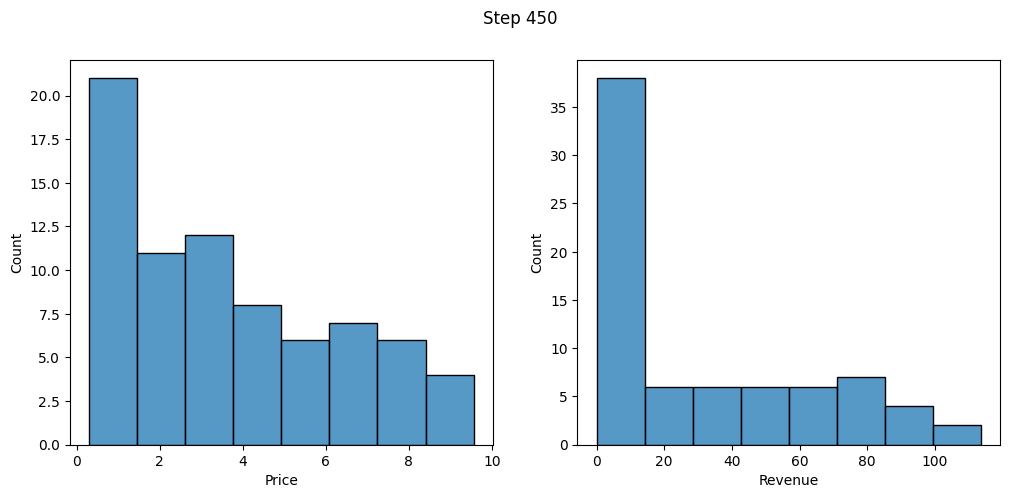

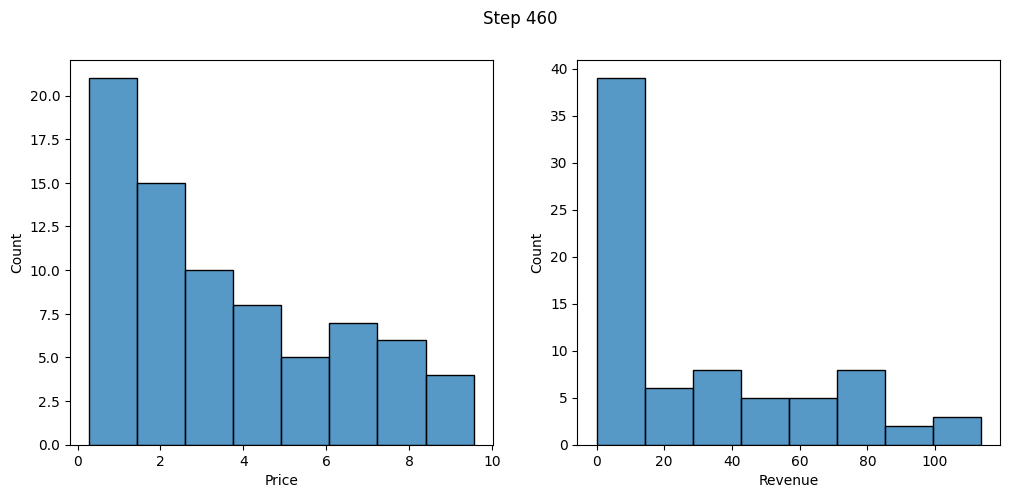

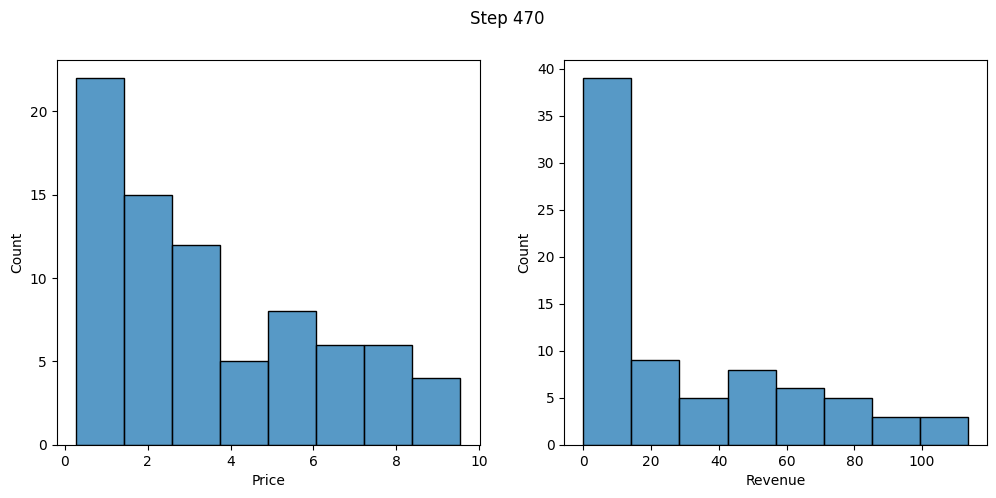

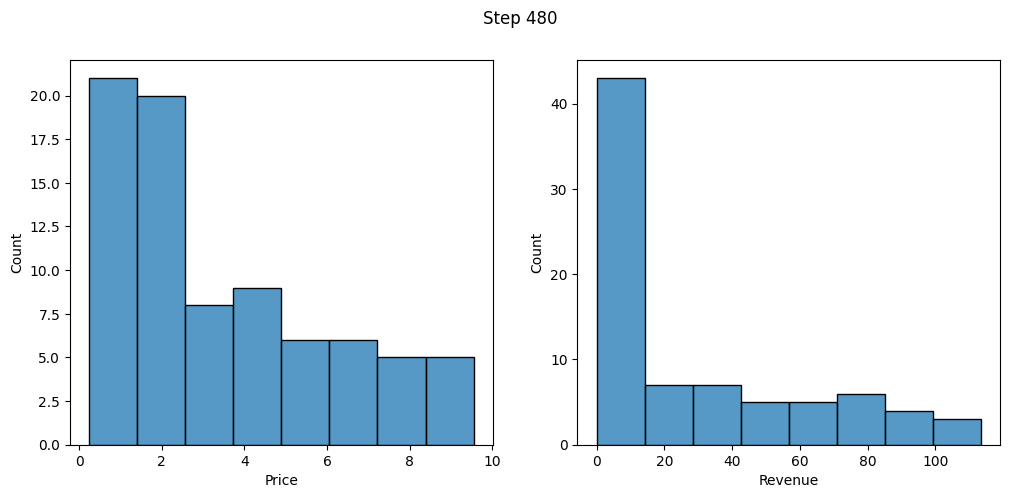

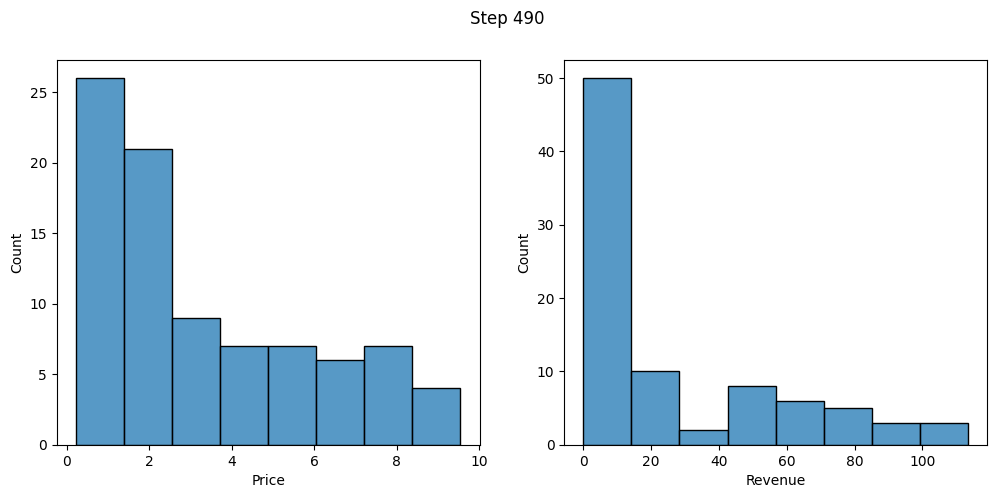

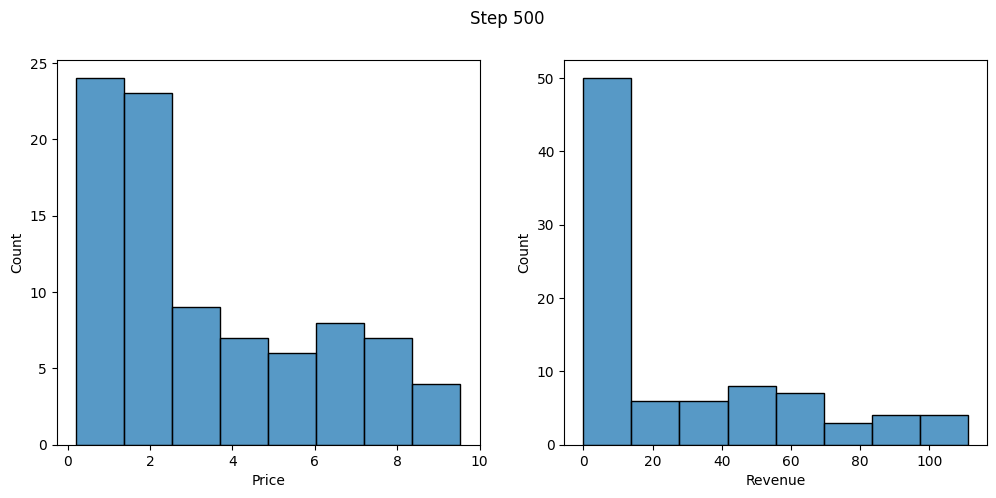

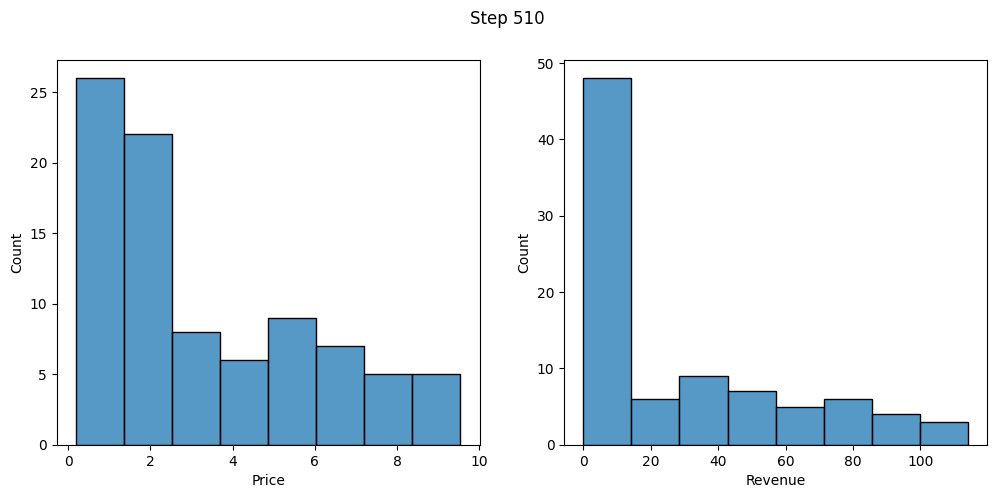

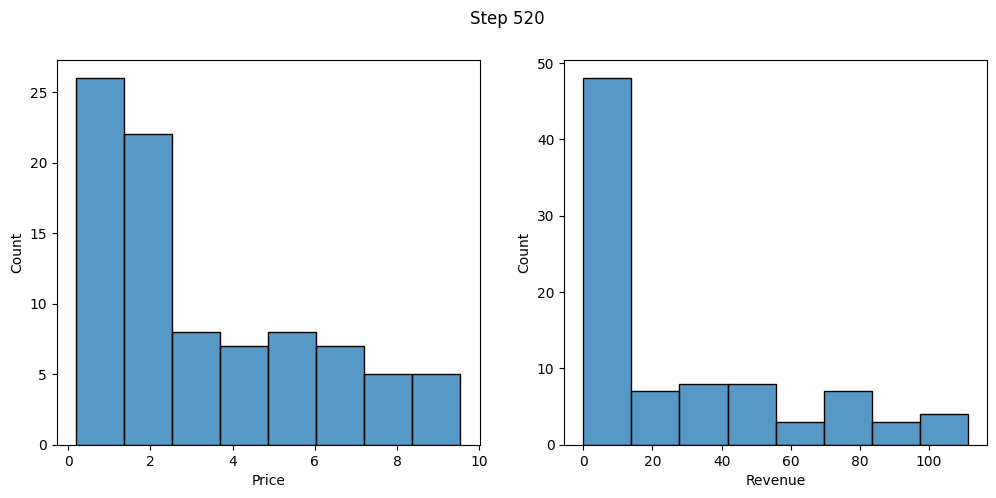

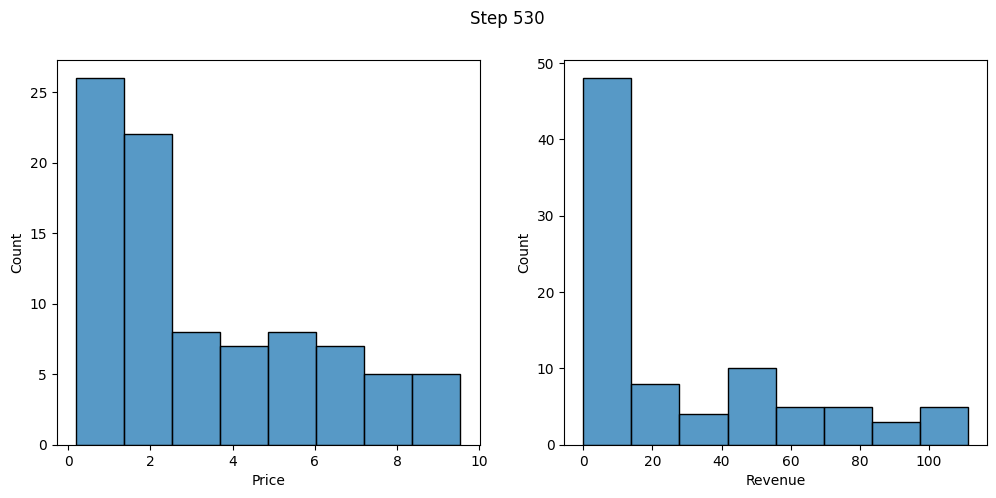

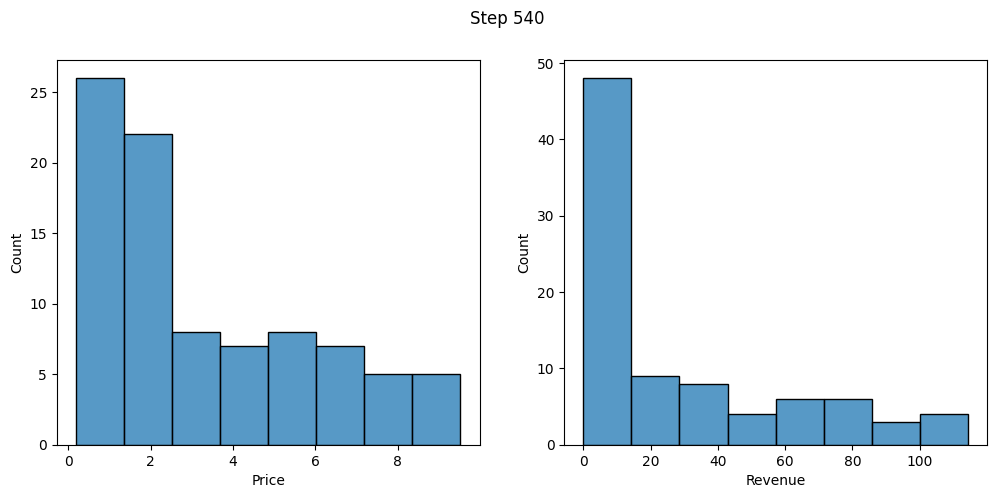

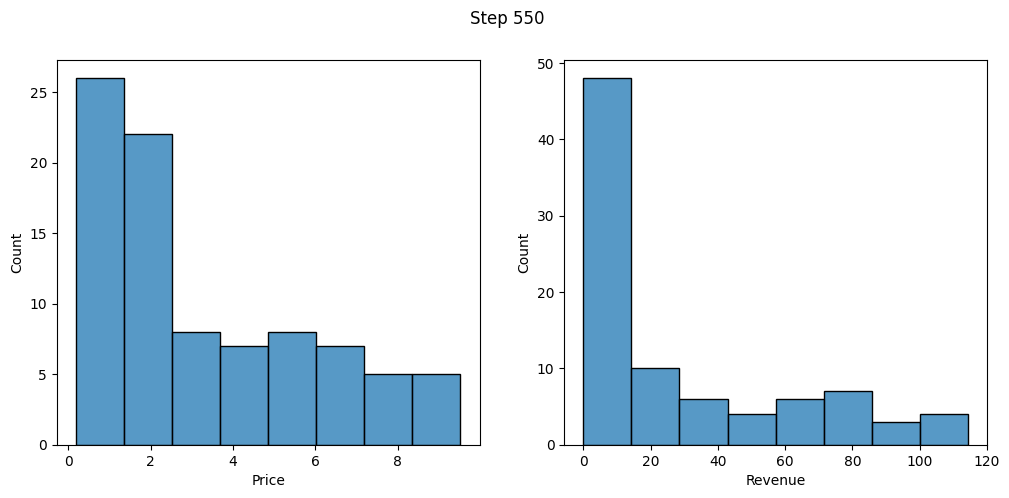

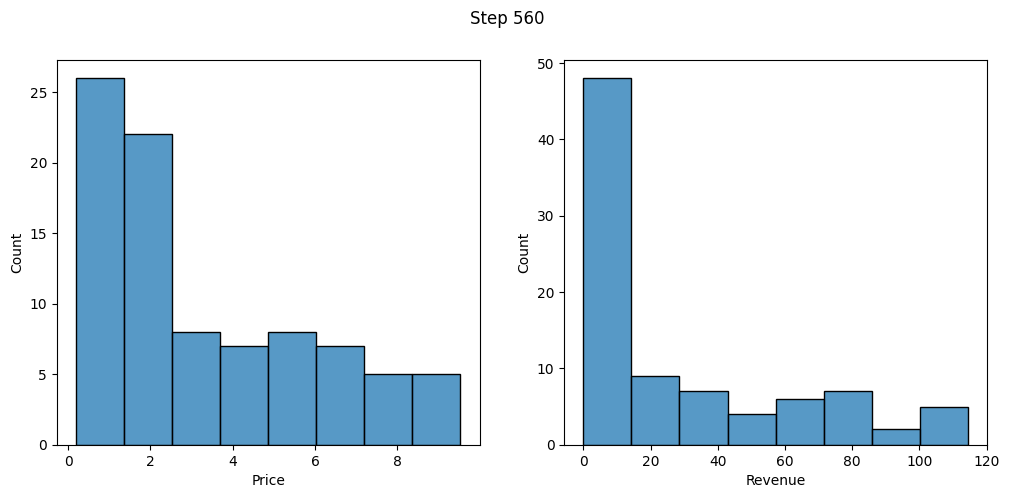

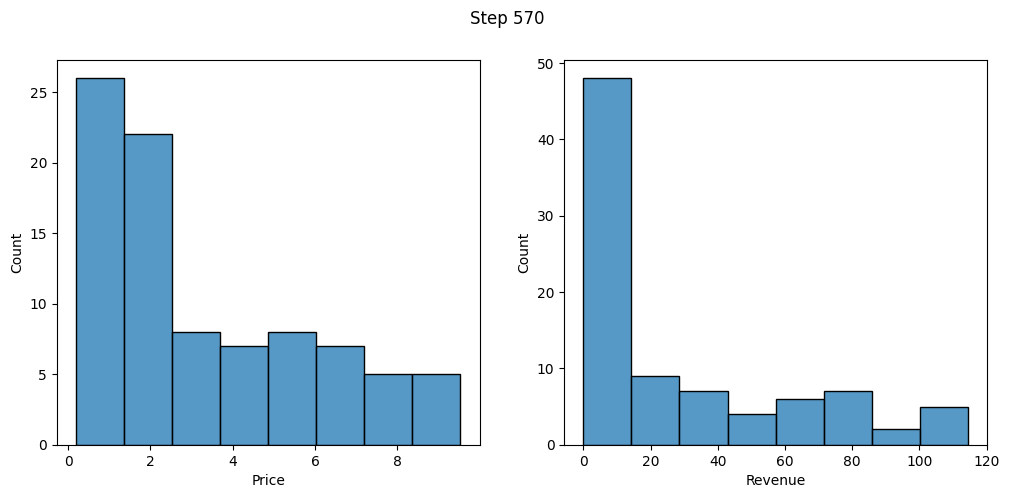

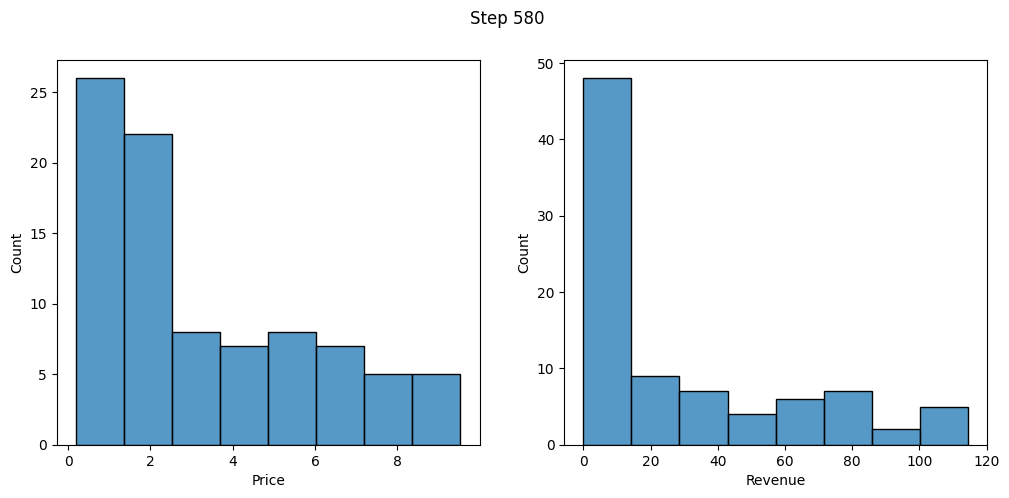

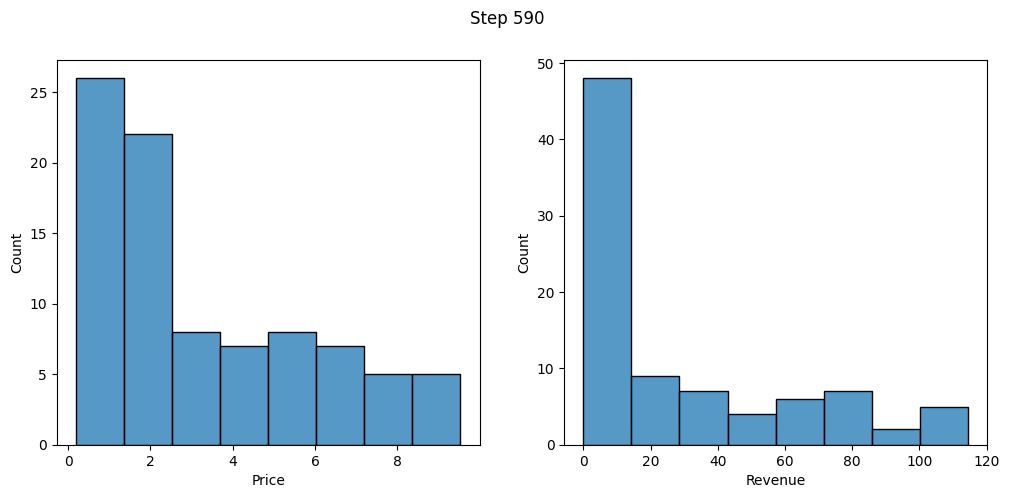

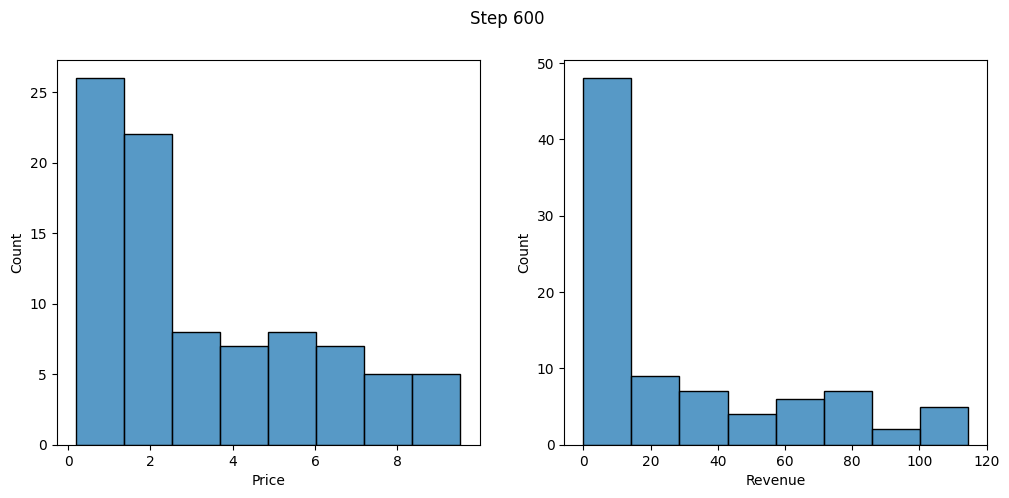

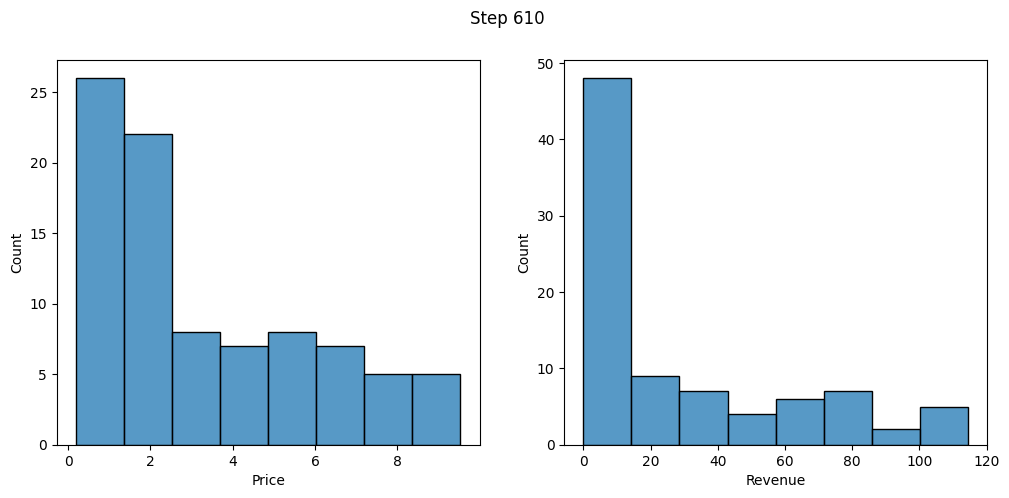

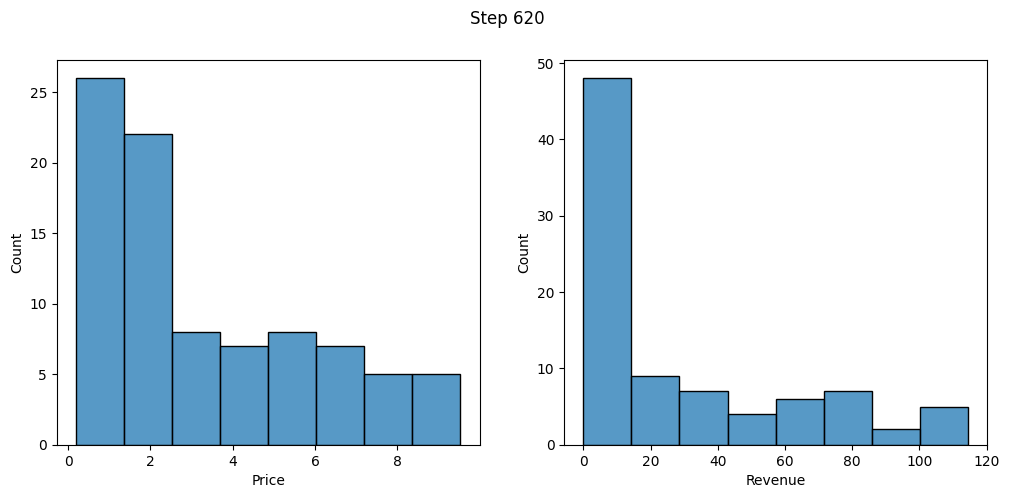

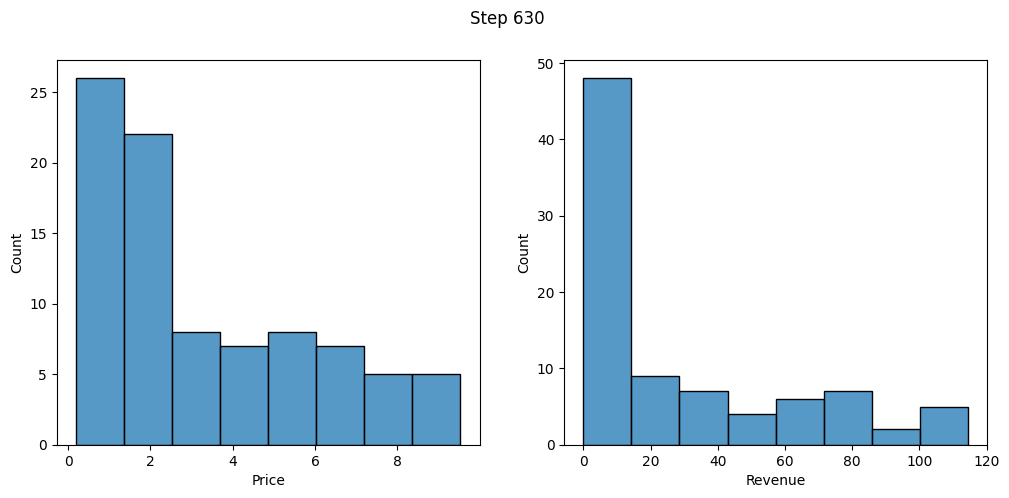

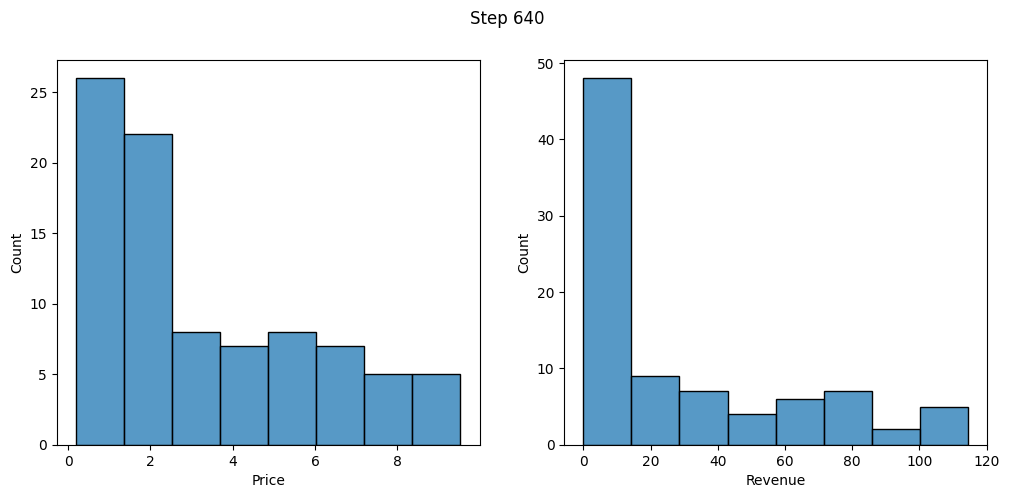

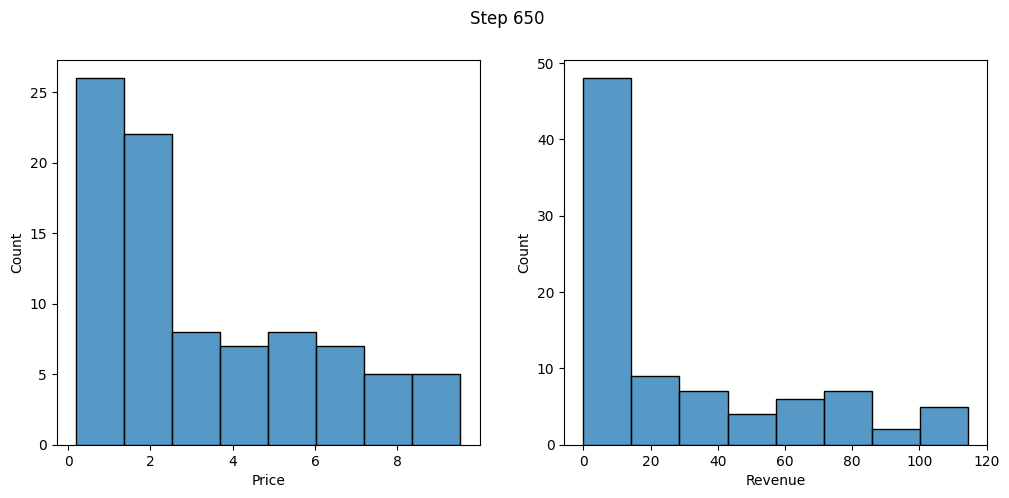

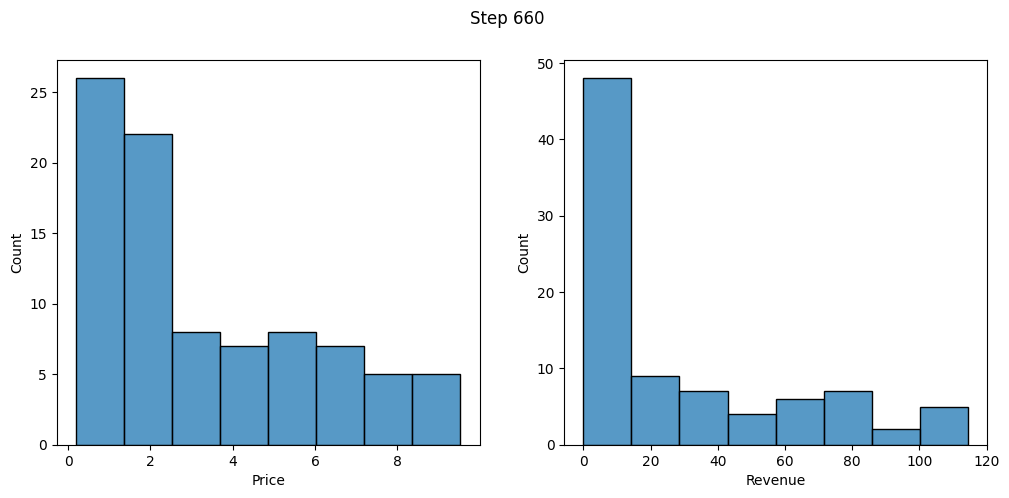

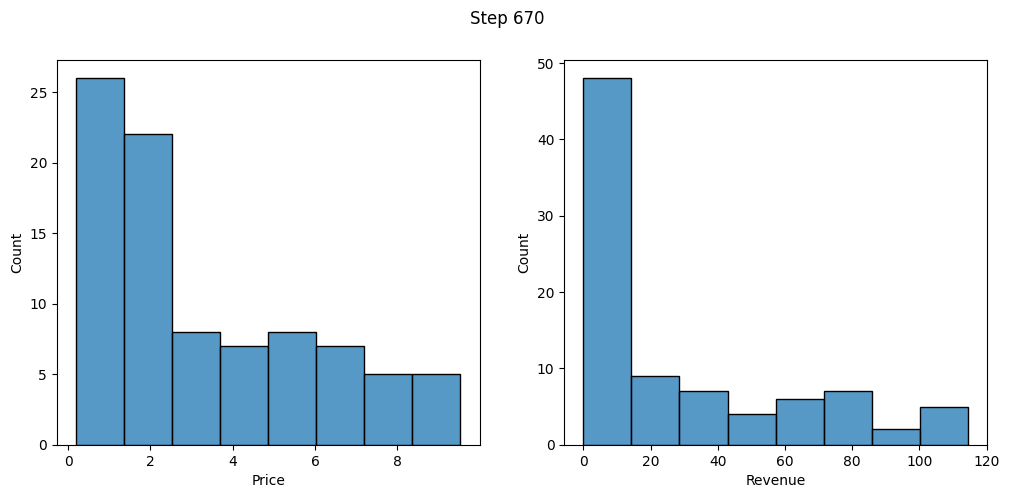

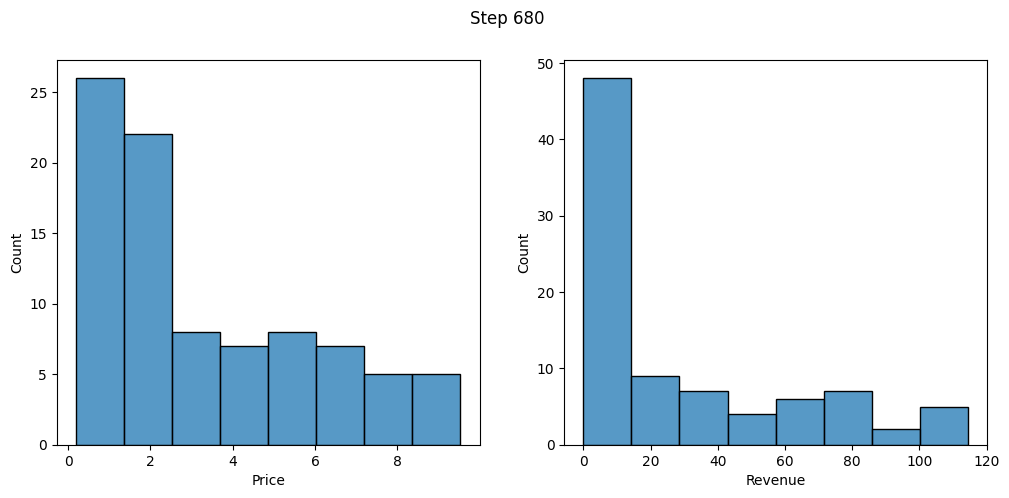

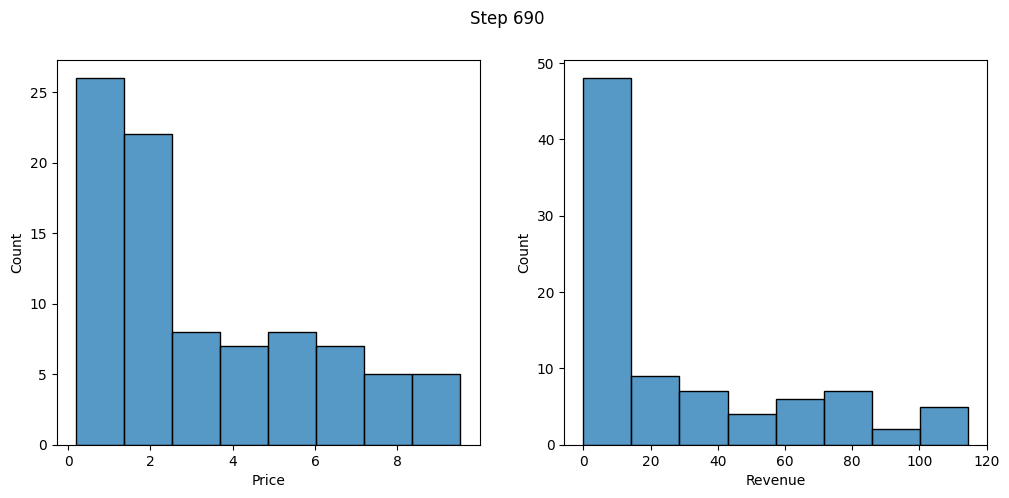

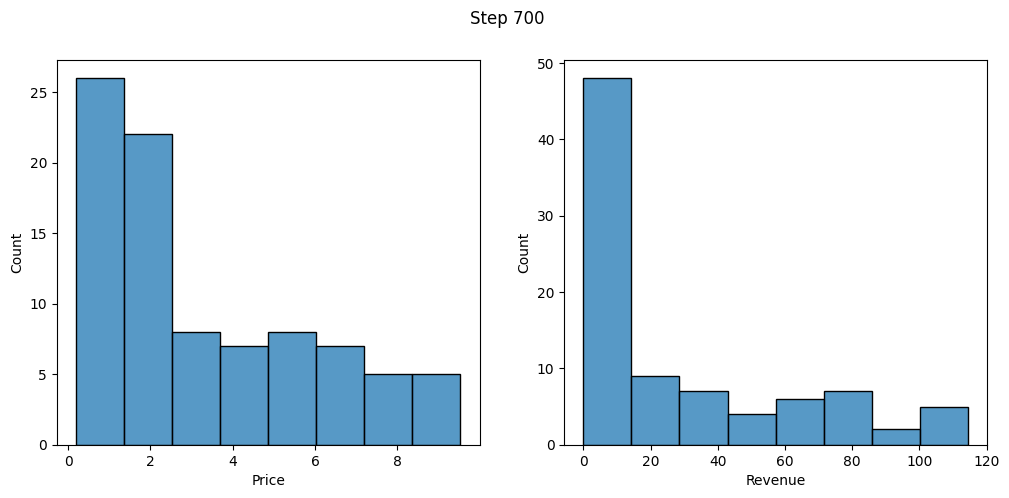

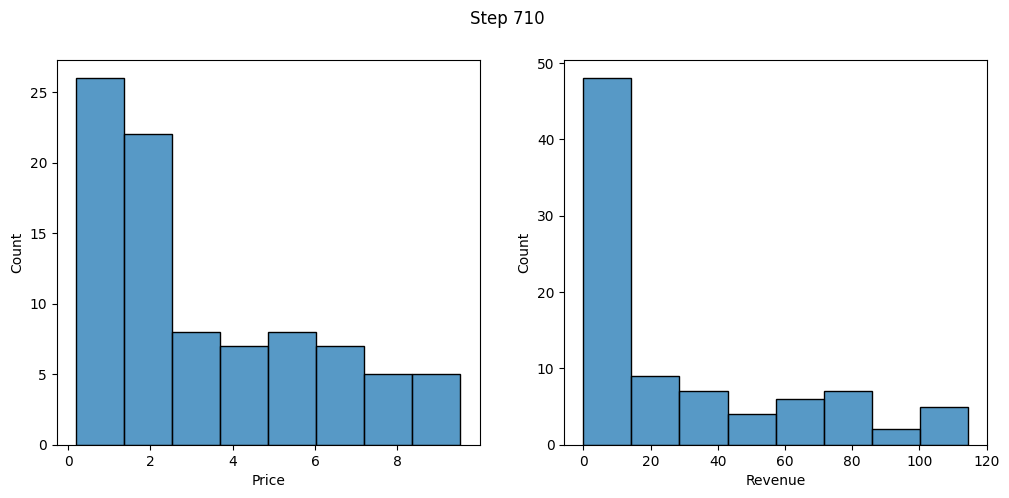

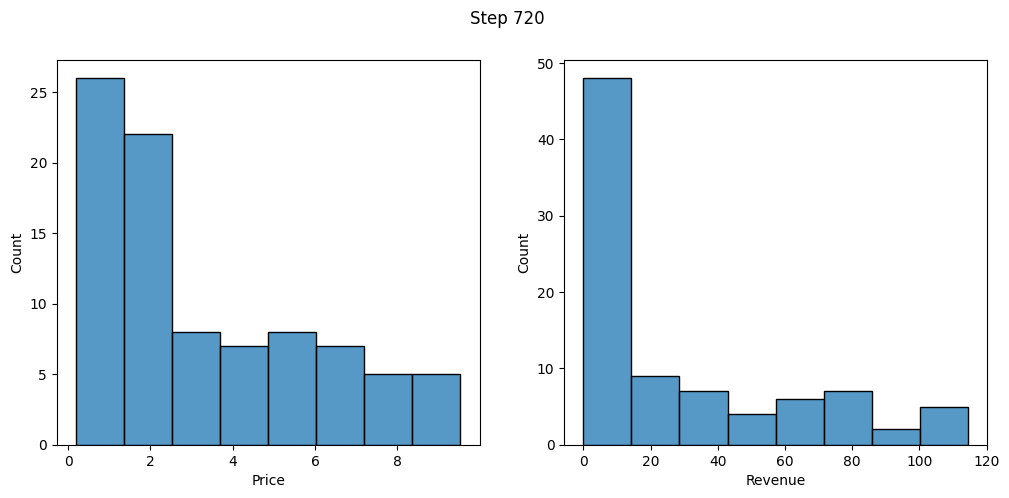

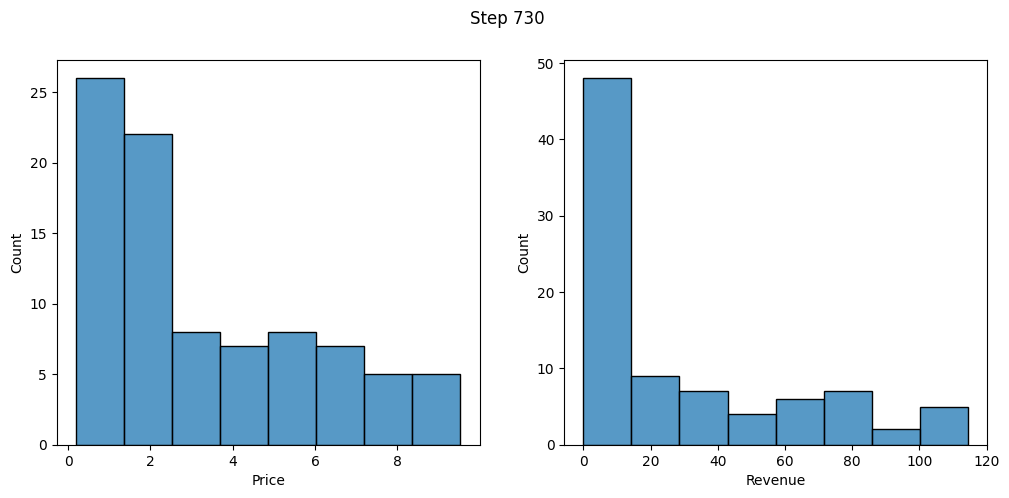

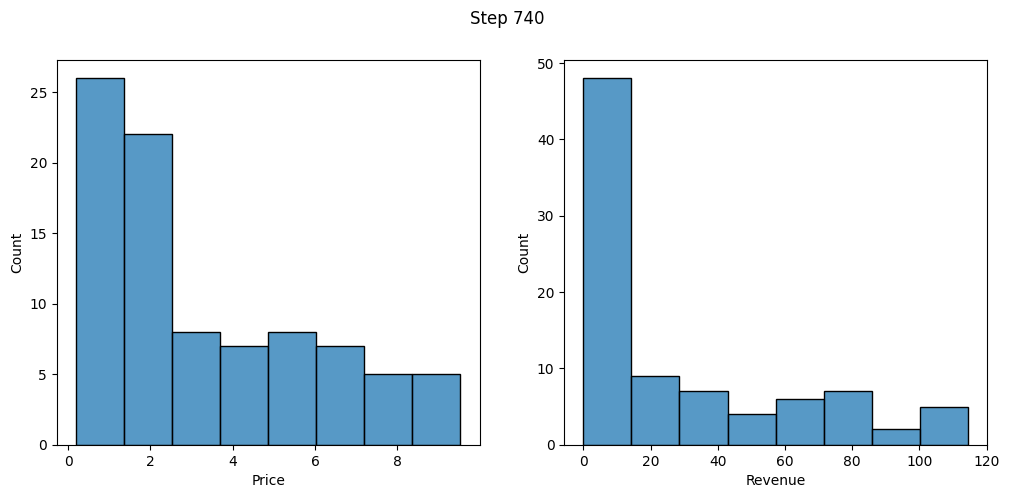

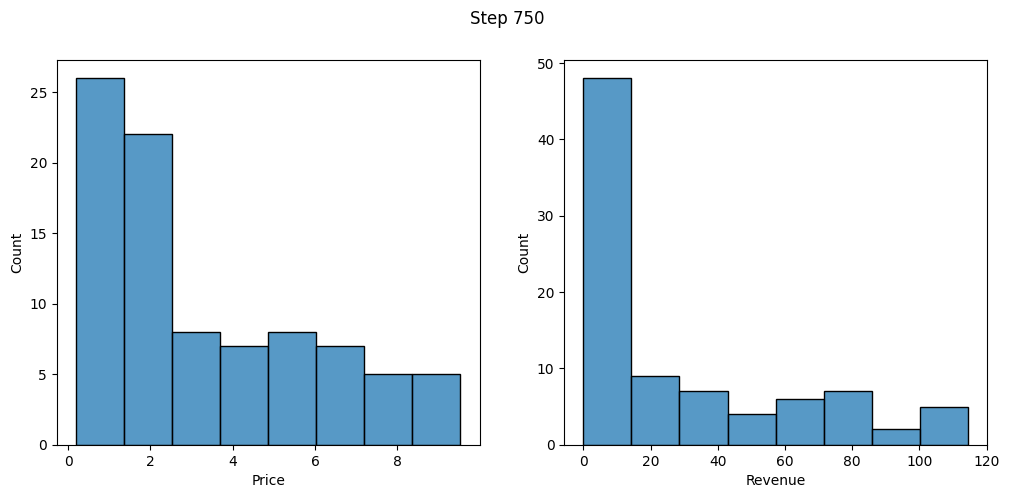

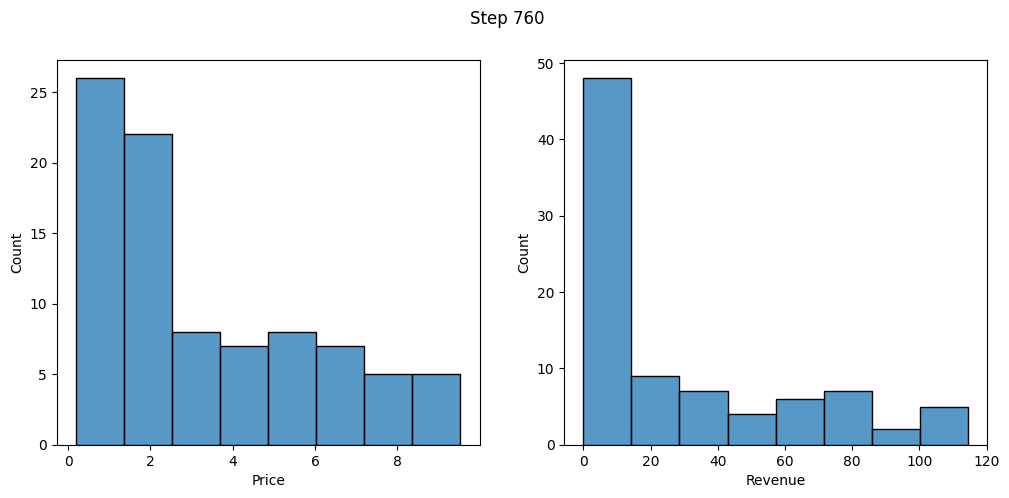

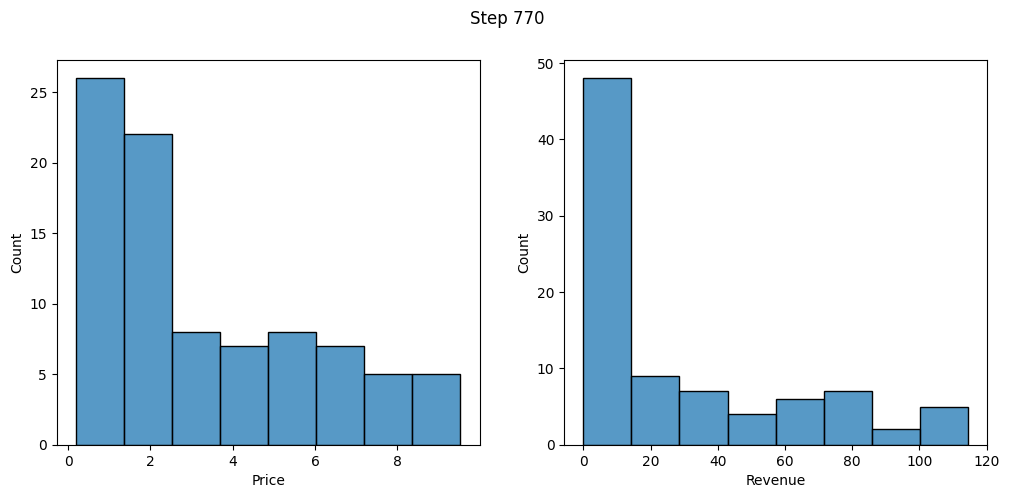

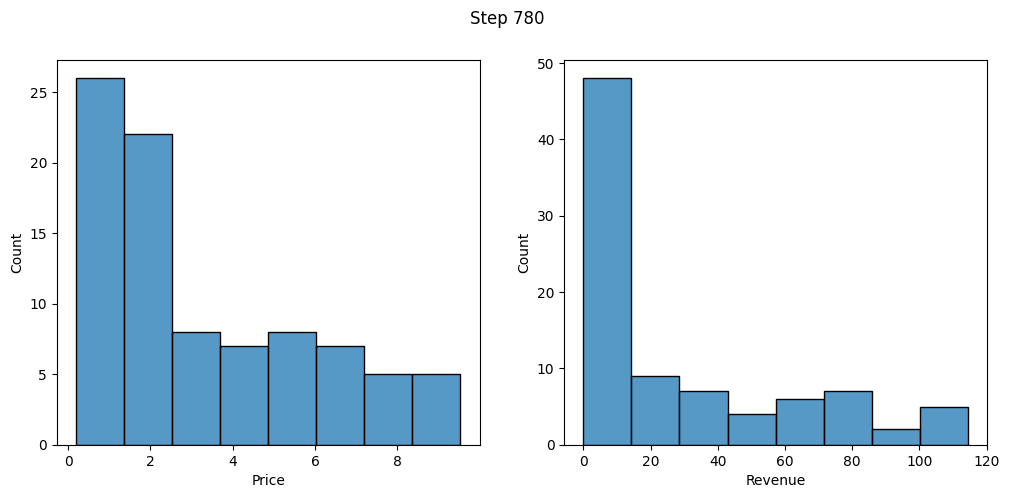

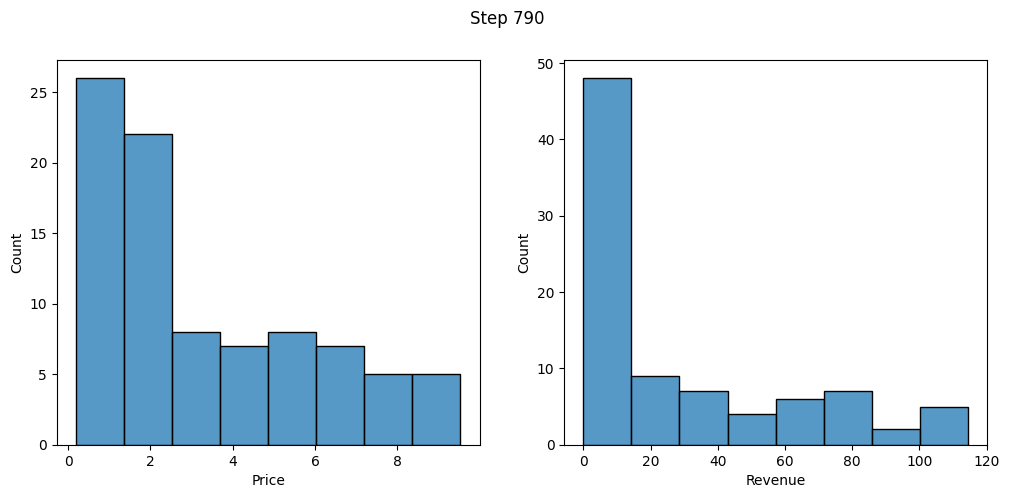

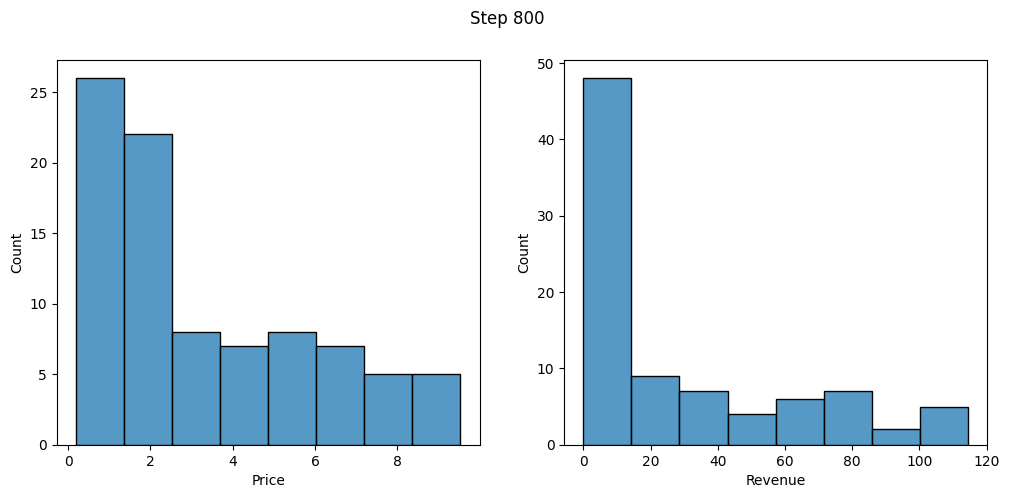

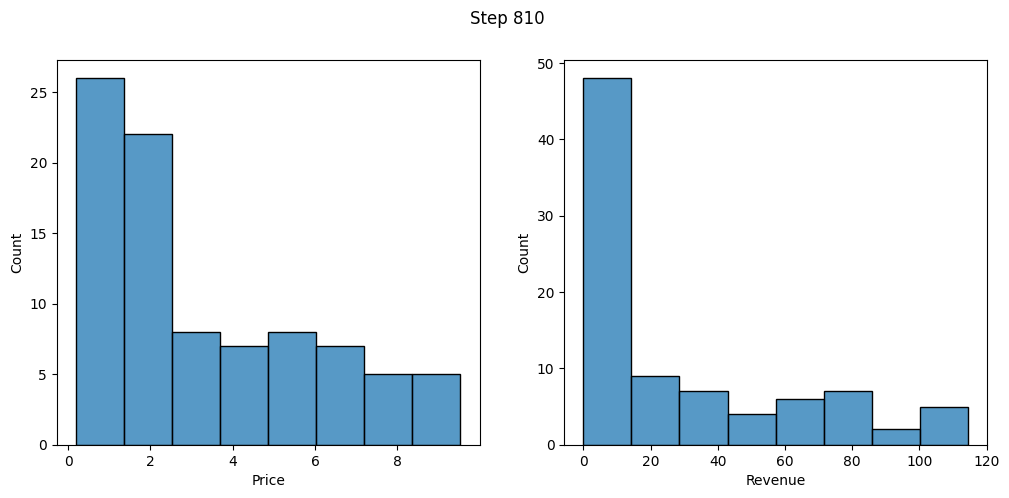

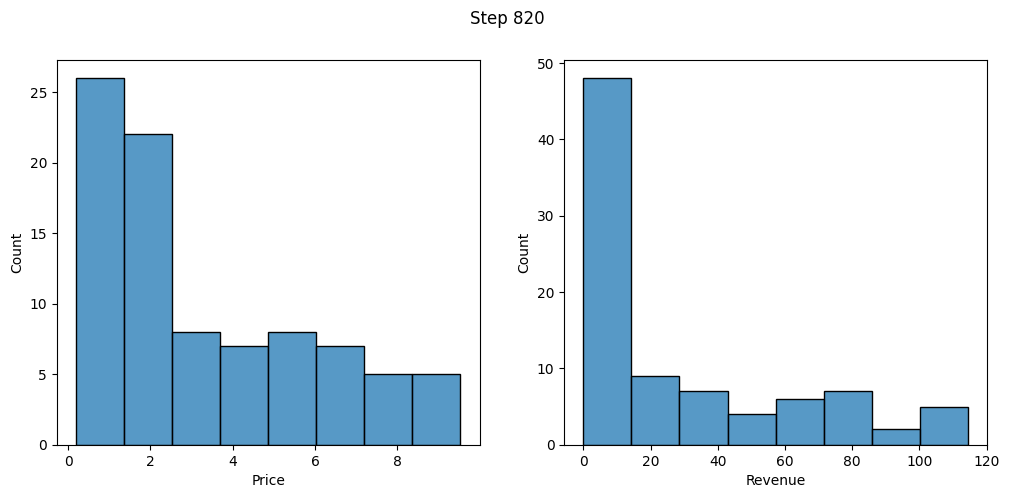

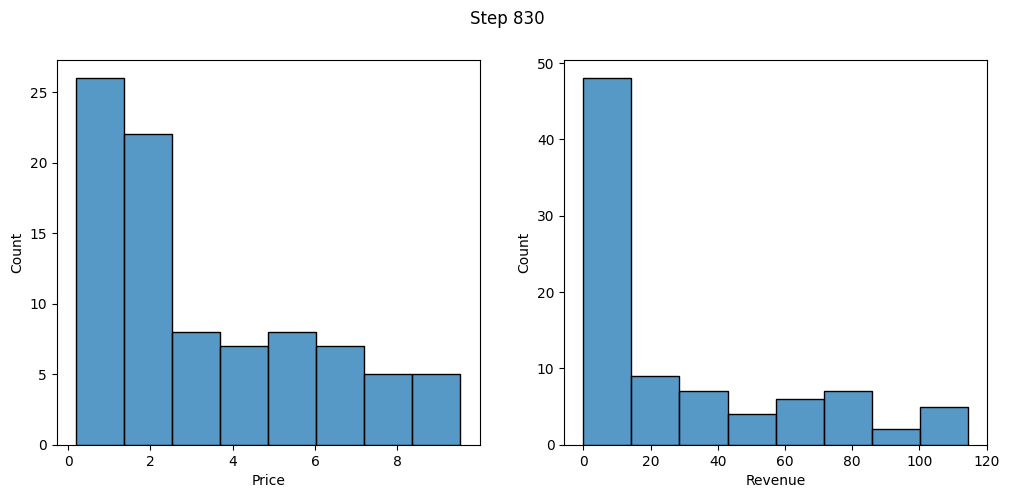

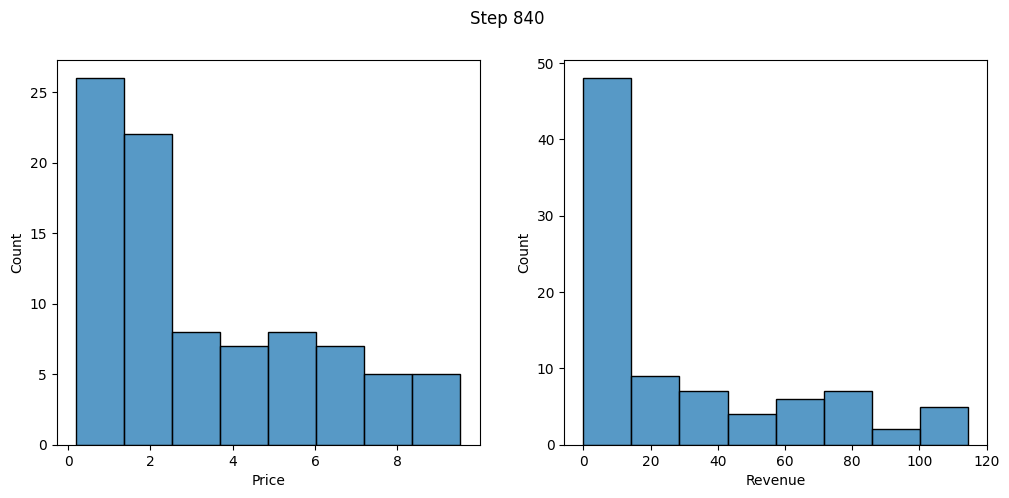

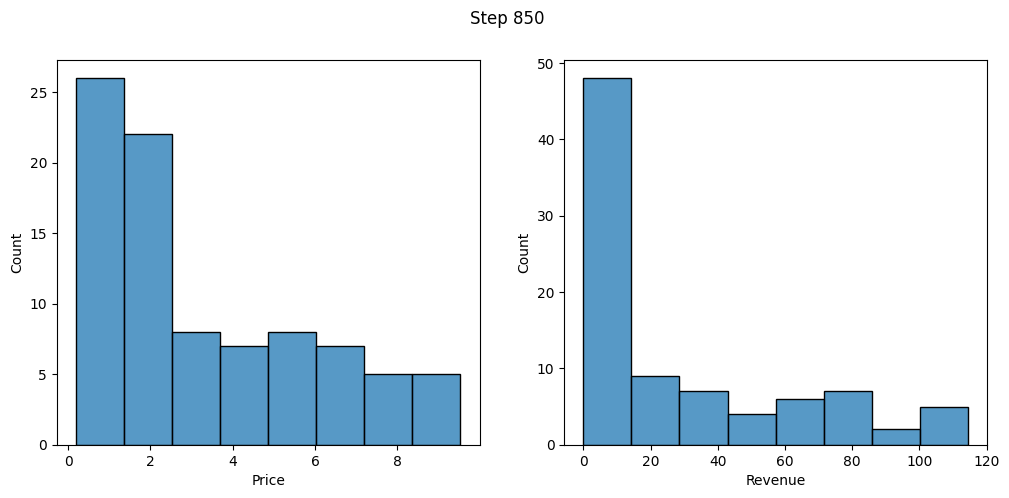

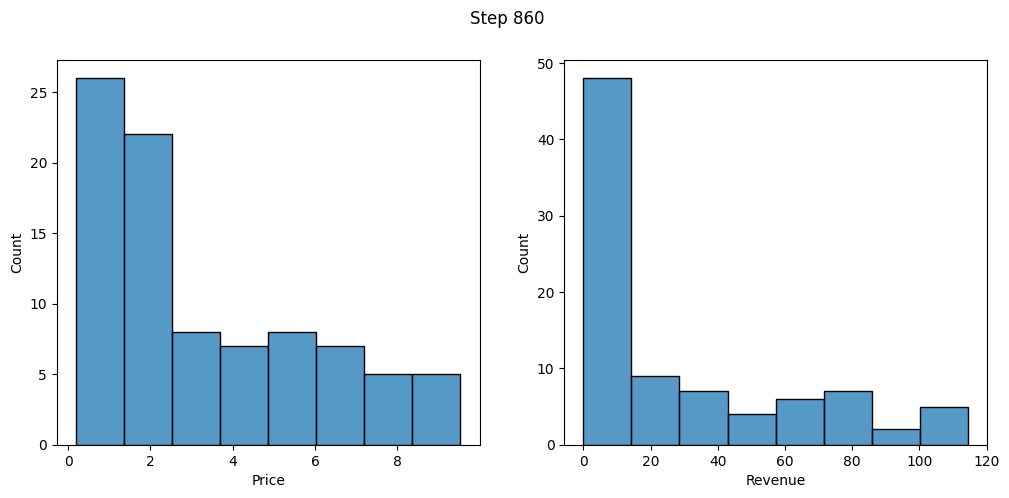

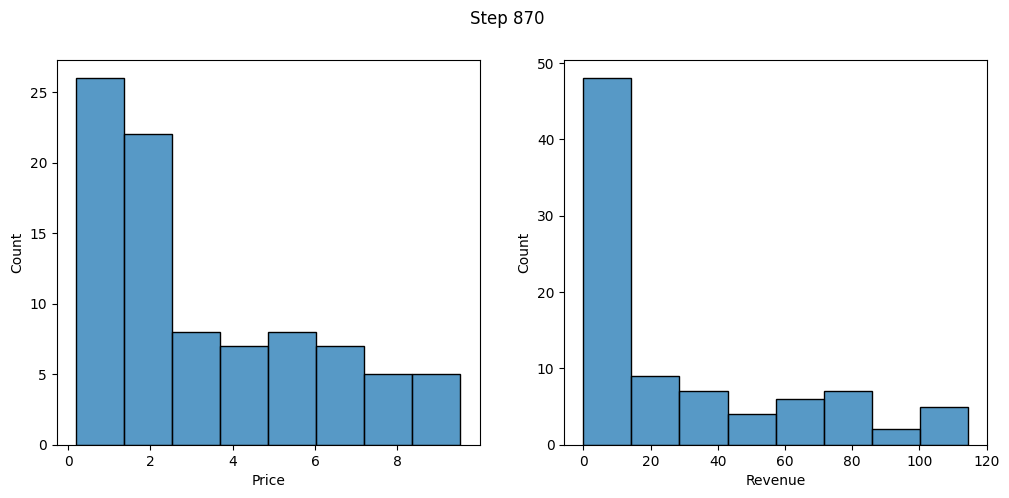

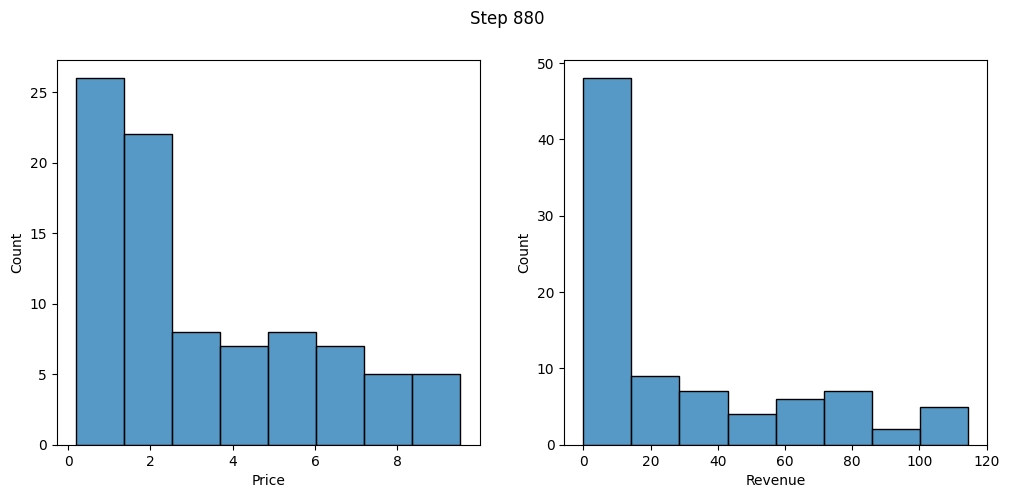

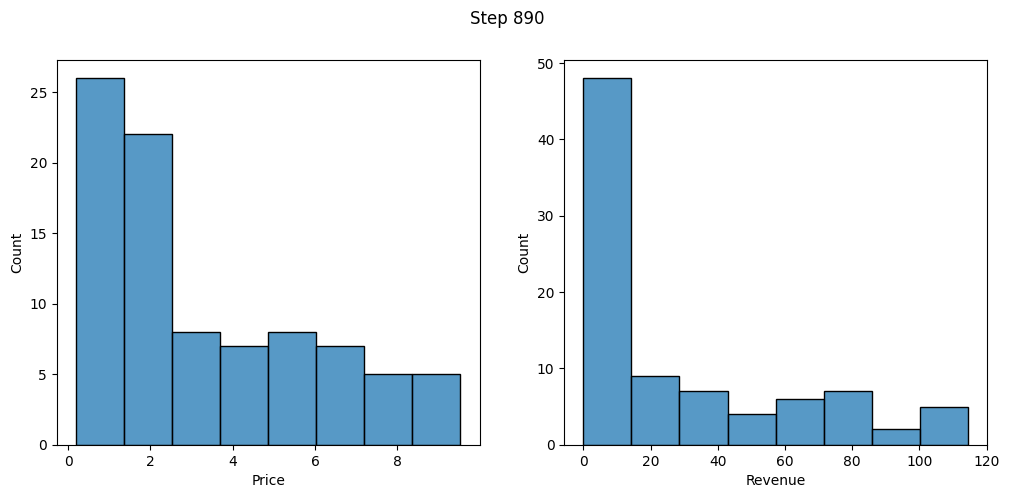

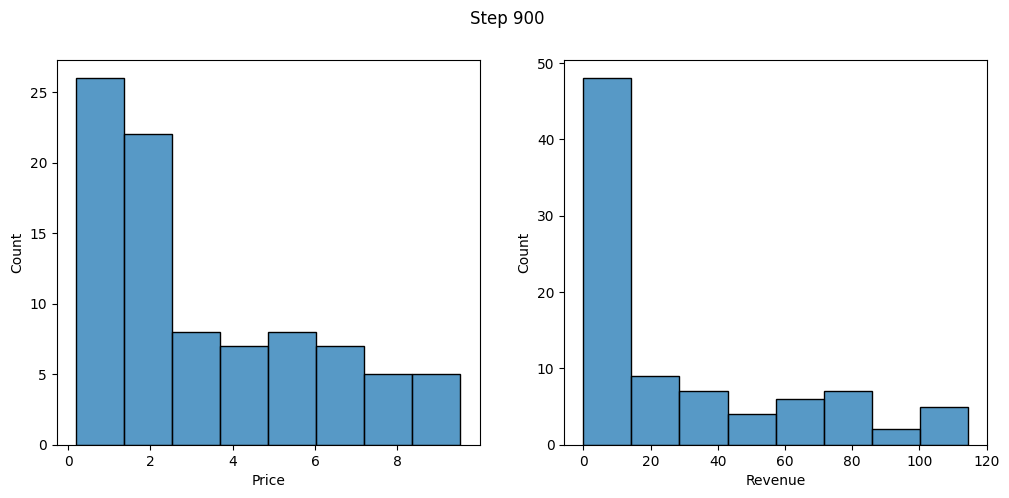

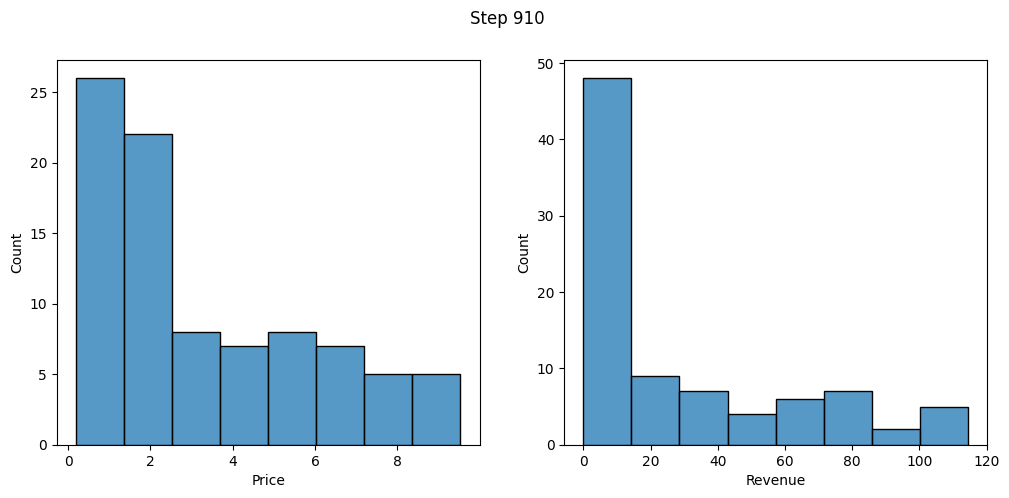

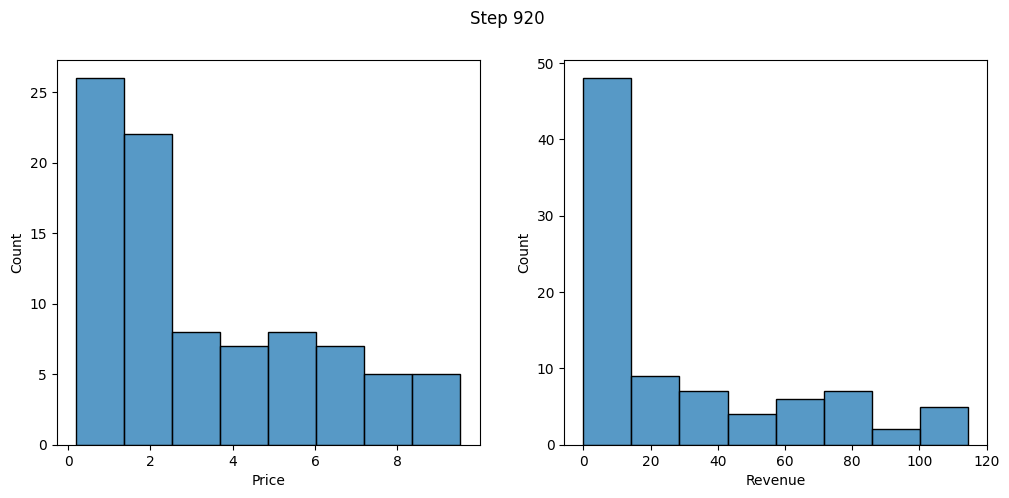

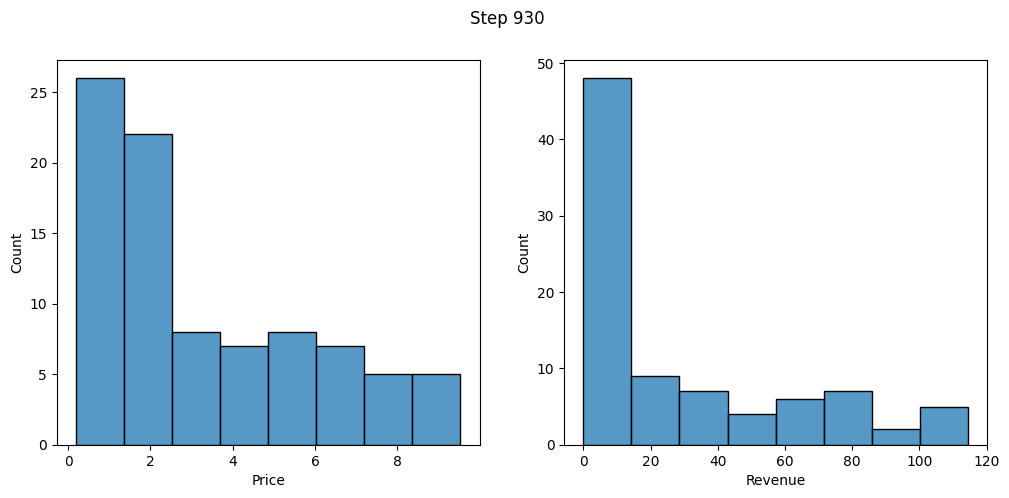

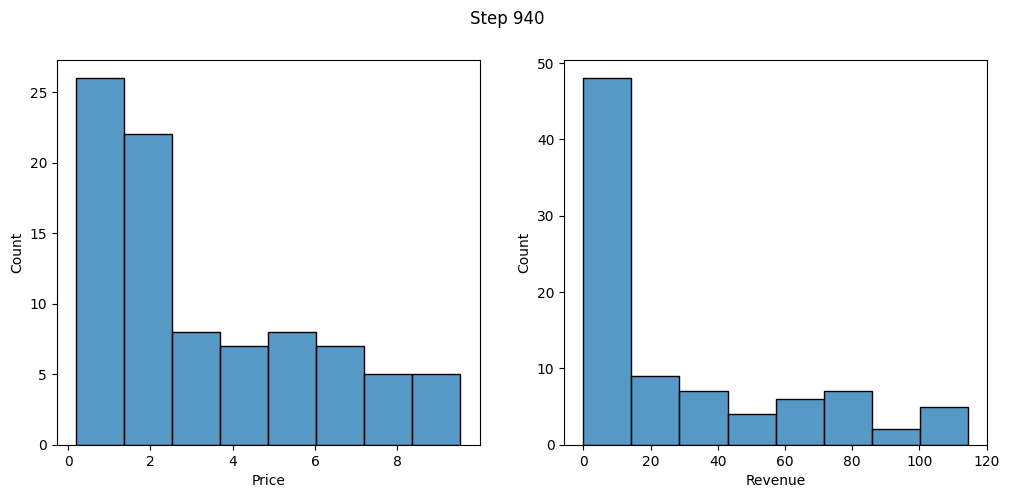

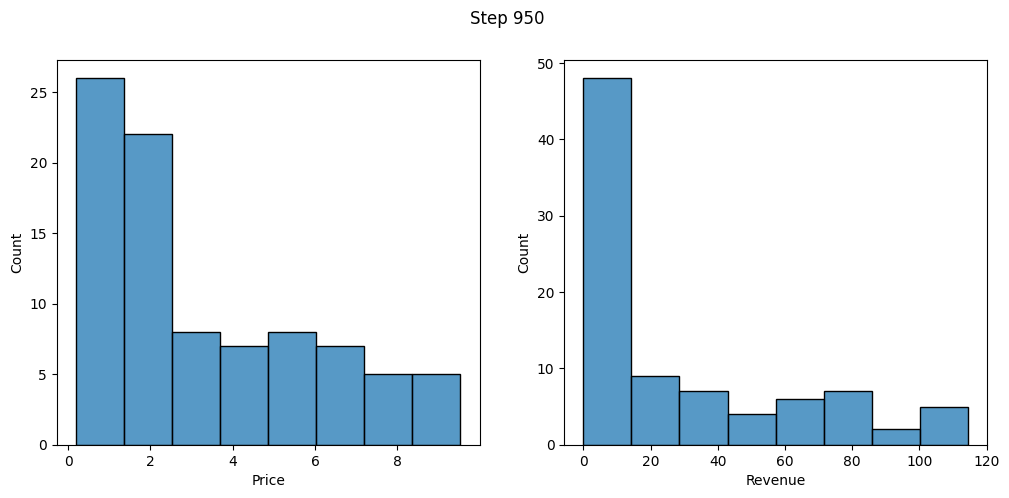

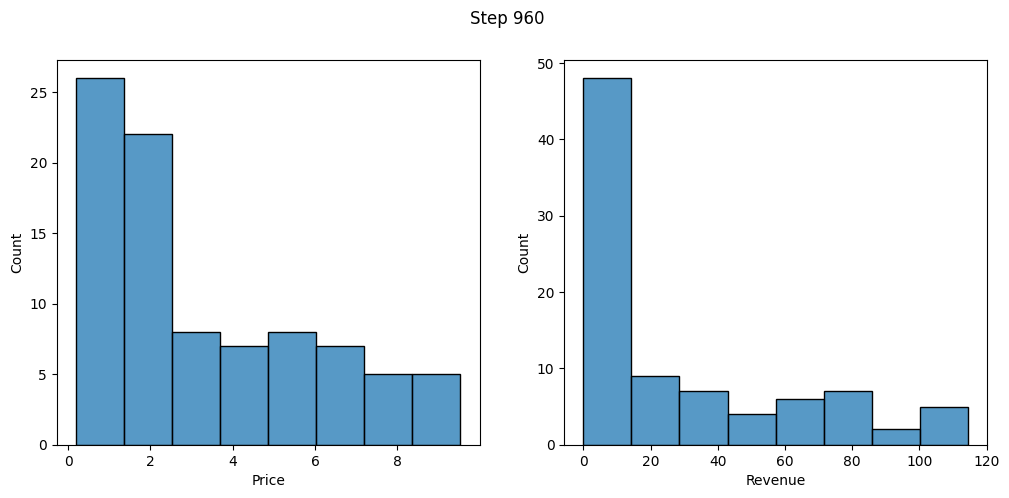

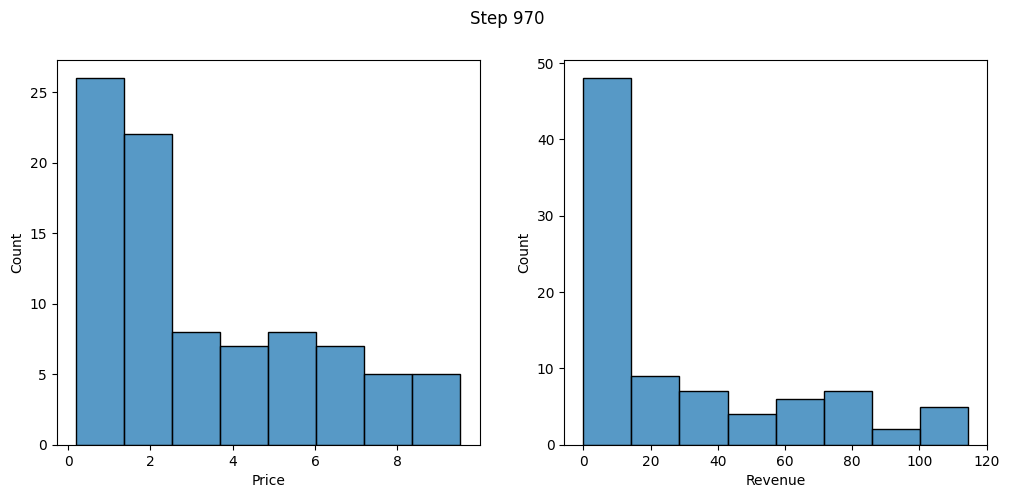

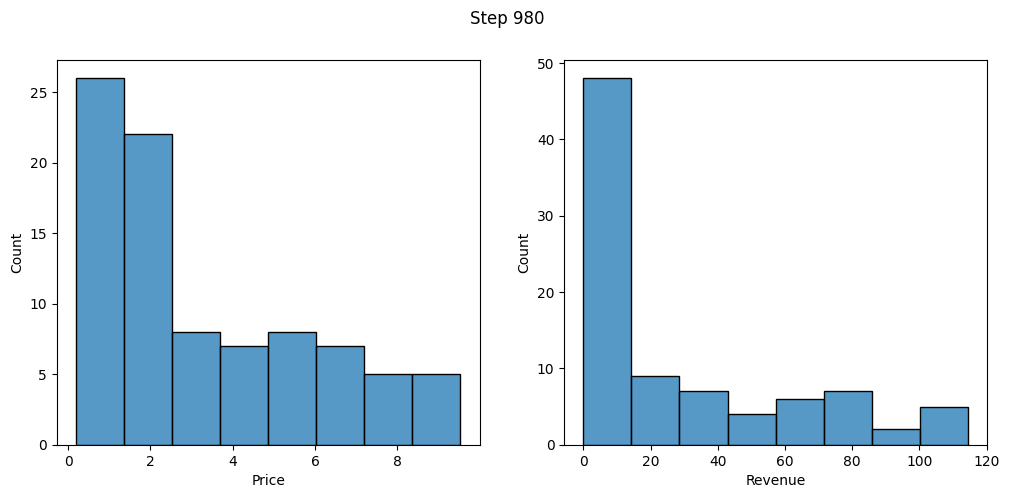

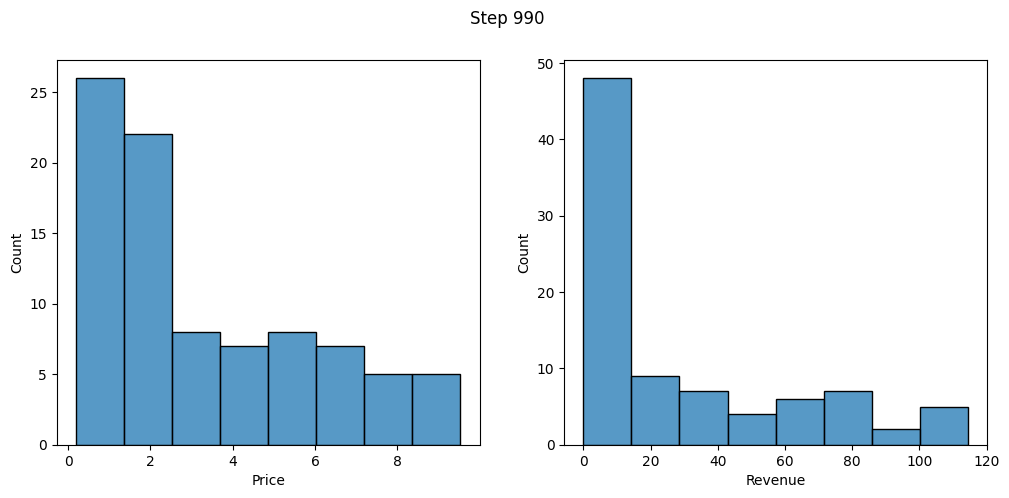

In [23]:

# for each step plot use seaborn to do a 1x2 plot with the distribution of the "Price" and "Revenue" of the firms
for i in range(steps):
    if i % 10 == 0:
        df1 = df[df["Step"] == i]
        df1 = df1[df1["Type"] == "Firm"]
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        sns.histplot(df1["Price"], ax=ax[0])
        sns.histplot(df1["Revenue"], ax=ax[1])
        # set the title of the plot to the step
        fig.suptitle("Step " + str(i))
        plt.show()


In [24]:
firms = df.loc[df['Type'] == "Firm"]
df.loc[(df['Type'] == "Firm") & (df['Step'] == 99)]['Revenue'].sum()
hhi = pd.DataFrame(data={'step': range(0,100)})
hhi = hhi.assign(volume=lambda x: df.loc[(df['Type'] == "Firm") & (df['Step'] == x.step)]['Revenue'].sum())
hhi 

ValueError: Can only compare identically-labeled Series objects